**Overall Gas production prediction**

**-Exponential Smoothing**

**-SARIMA Model**

**-SARIMAX Model**

**- VAR Model**

In [1]:
from sqlalchemy import create_engine, MetaData, or_, and_
from sqlalchemy import select, func 
from db_schema import OIL_PROD_TABLE, GAS_PROD_TABLE, LEASE_TABLE, WELLS_TABLE, TOPS_TABLE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
class CFG:
    img_dim1 = 16
    img_dim2 = 12
    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

In [3]:
engine = create_engine("sqlite:///../../kansas_oil_gas.db")
# Reflect oil production table
meta = MetaData()
meta.reflect(bind=engine)
oil_prod = meta.tables[OIL_PROD_TABLE]
gas_prod = meta.tables[GAS_PROD_TABLE]
lease = meta.tables[LEASE_TABLE]
wells = meta.tables[WELLS_TABLE]
tops = meta.tables[TOPS_TABLE]

In [4]:
s = select(
    [
        gas_prod.c.DATE,
        func.sum(gas_prod.c.WELLS).label("N_WELLS"),
        func.sum(gas_prod.c.PRODUCTION).label("MONTHLY_GAS_PROD"),
    ]
).group_by(gas_prod.c.DATE)
df_gas_prod = pd.read_sql(s, engine)

df_gas_prod.head()

DATE  N_WELLS  MONTHLY_GAS_PROD
0  1980-01-01     9790        83334247.0
1  1980-02-01     9210        73242455.0
2  1980-03-01     9727        70940951.0
3  1980-04-01     9508        59003694.0
4  1980-05-01     9232        47541659.0

In [5]:
df_gas_prod['DATE'] = pd.to_datetime(df_gas_prod['DATE'])
df_gas_prod.set_index('DATE', inplace = True)
df_gas_prod.head()

N_WELLS  MONTHLY_GAS_PROD
DATE                                 
1980-01-01     9790        83334247.0
1980-02-01     9210        73242455.0
1980-03-01     9727        70940951.0
1980-04-01     9508        59003694.0
1980-05-01     9232        47541659.0

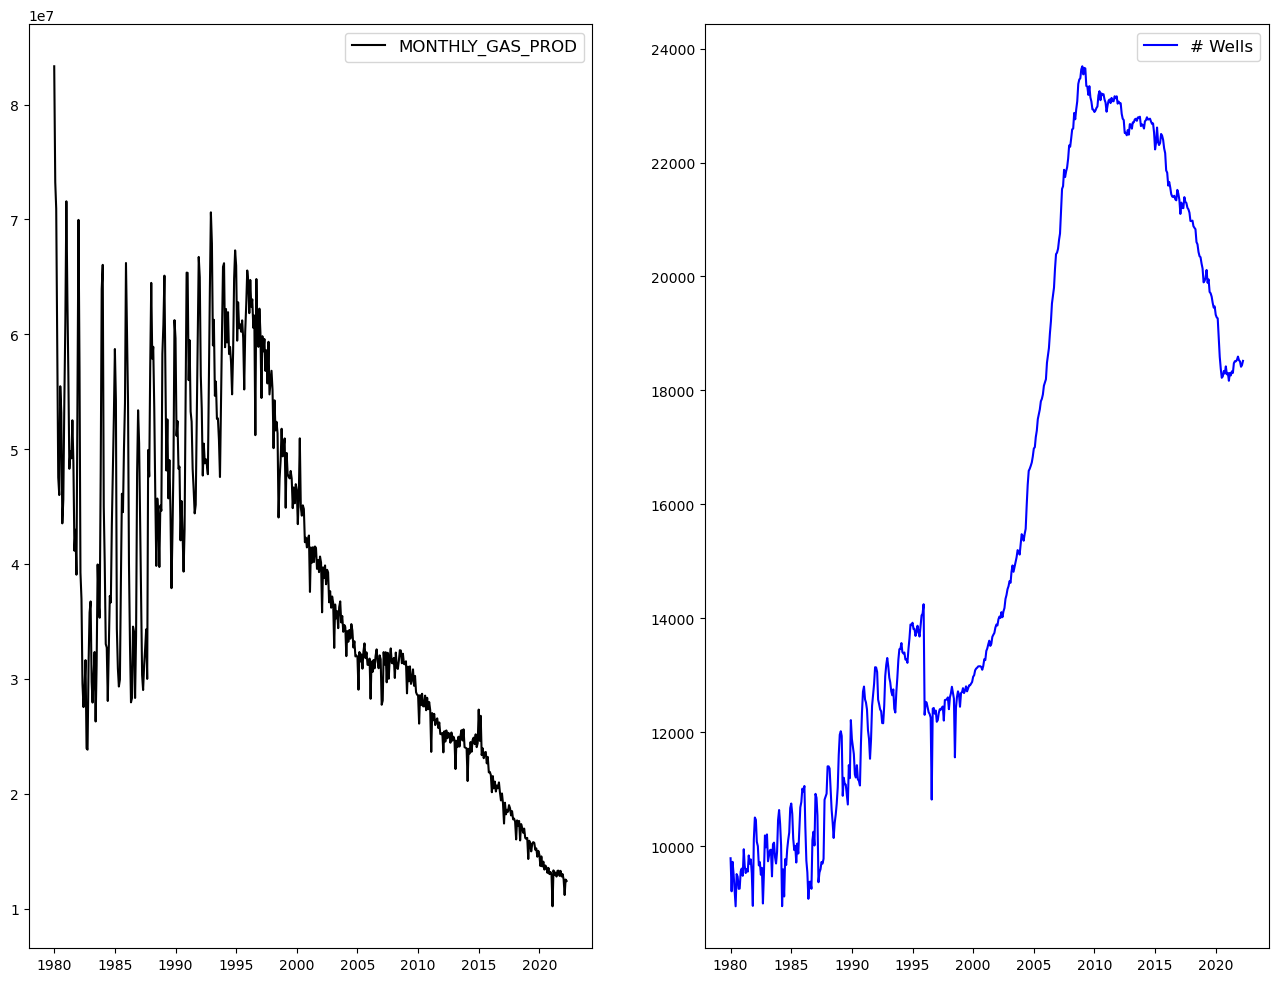

In [6]:
plt.subplot(1, 2, 2)

plt.subplot(1, 2, 1)
plt.plot(df_gas_prod['MONTHLY_GAS_PROD'], color='black', label='MONTHLY_GAS_PROD')
plt.legend(loc='upper right', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(df_gas_prod['N_WELLS'], color='blue', label='# Wells')
plt.legend(loc='upper right', fontsize=12)
plt.show()

**EDA: Seasonal decomposition**

Decompose the time series into trend, seasonality and the reminder (residual), which is the model can not account for.

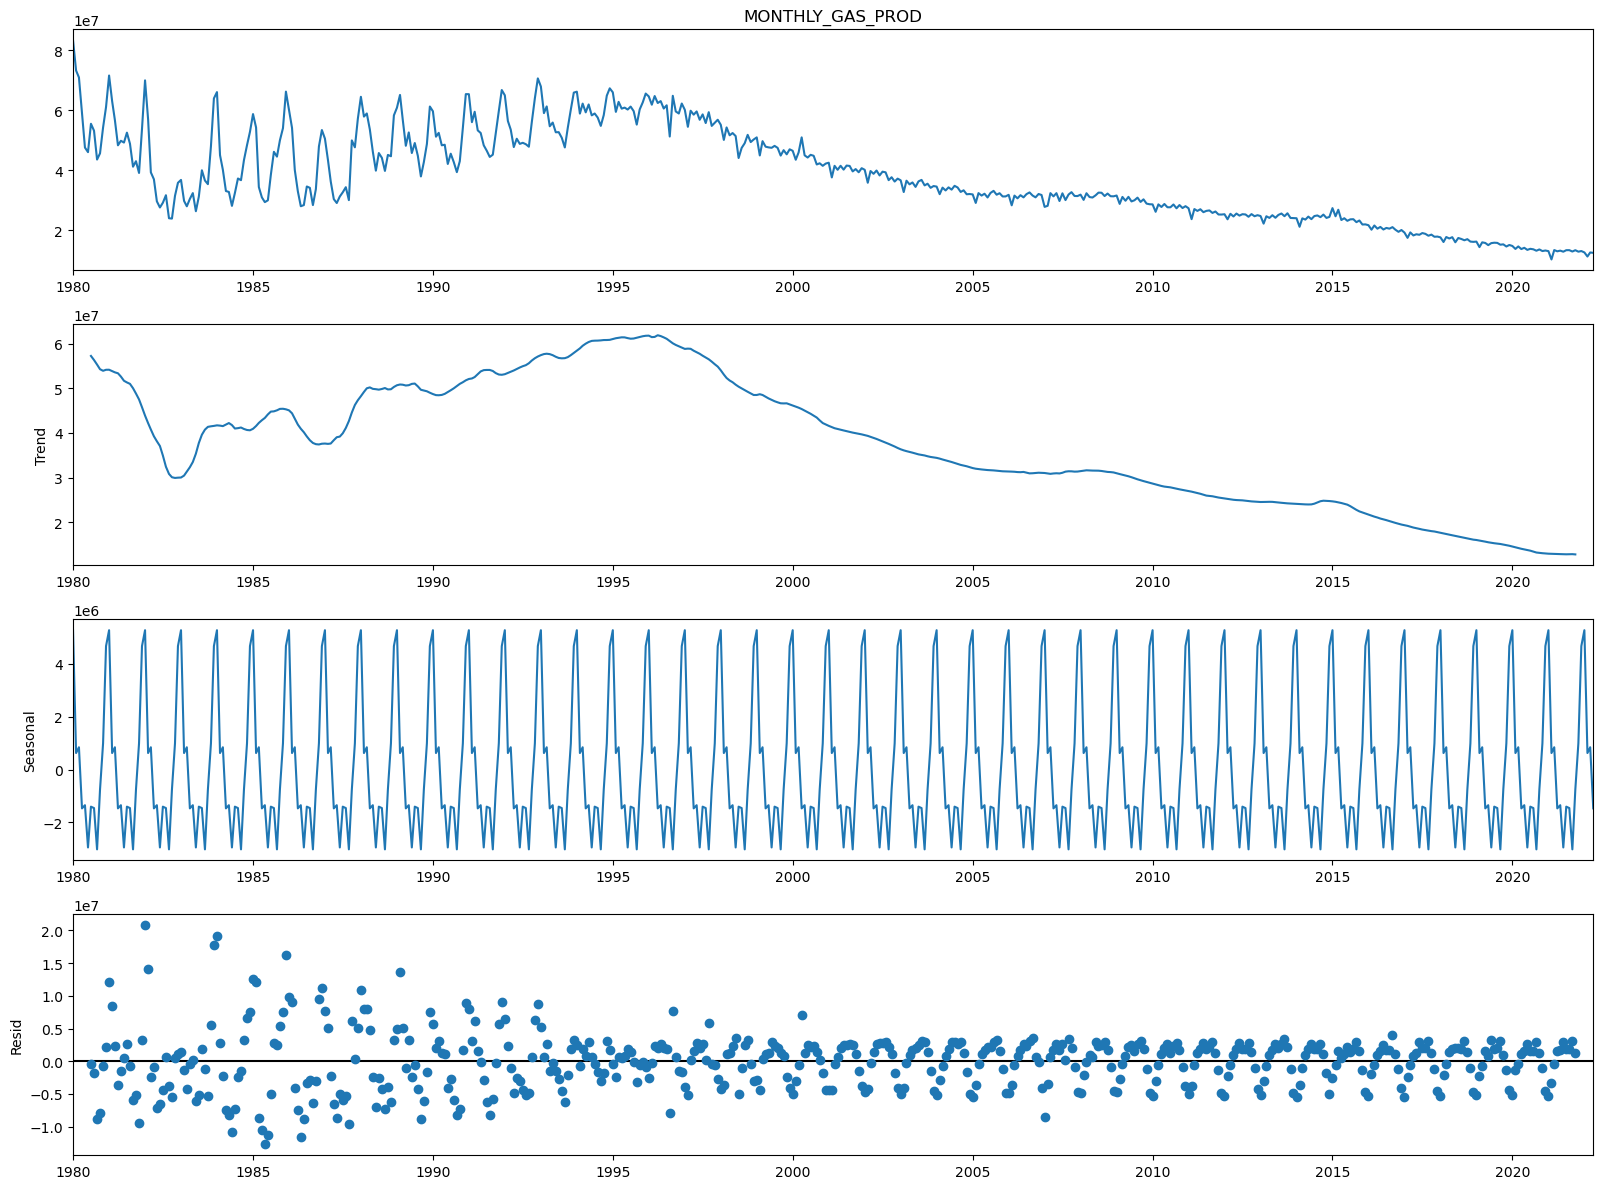

In [7]:
decomposition = seasonal_decompose(df_gas_prod['MONTHLY_GAS_PROD'], period = 12)
figure = decomposition.plot()
plt.show()

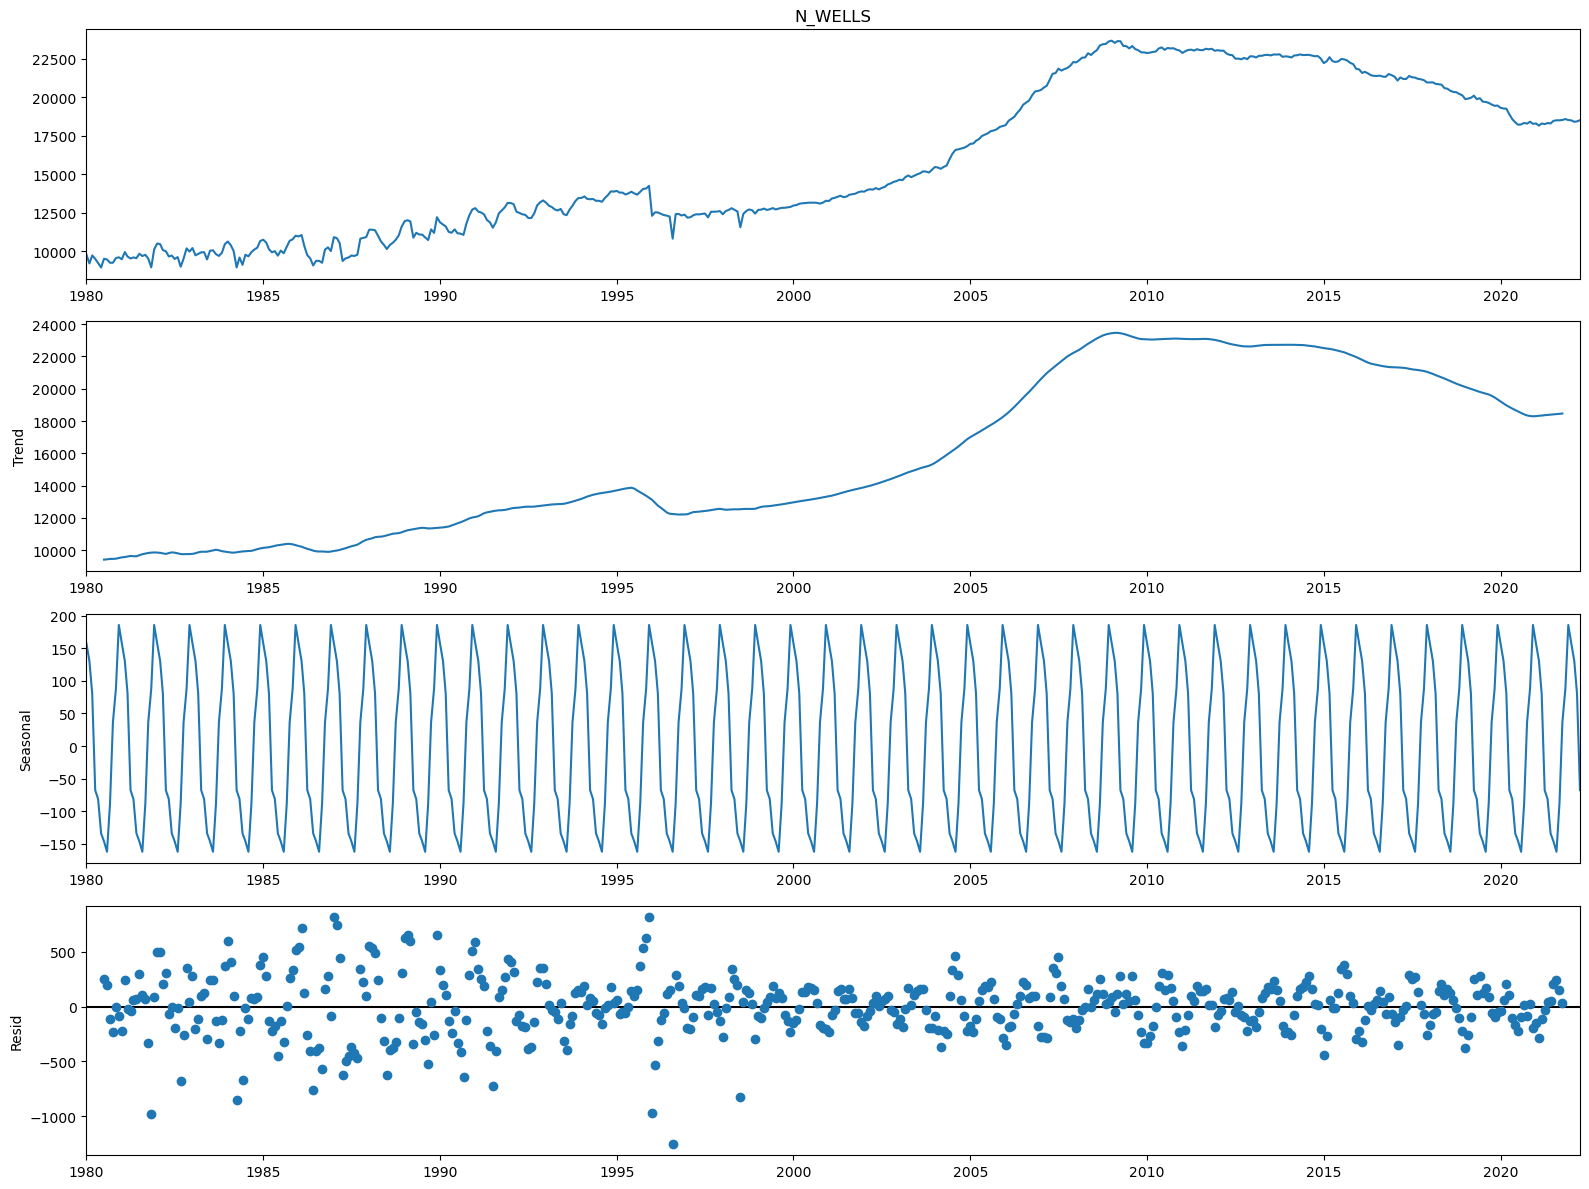

In [8]:
decomposition = seasonal_decompose(df_gas_prod['N_WELLS'], period = 12)
figure = decomposition.plot()
plt.show()

There is a clear trend - Gas production decreases overall

Also, there is clear seasonality.

Residuals - almost symmetrical around zero

Lets try "multiplicative" seasonality.

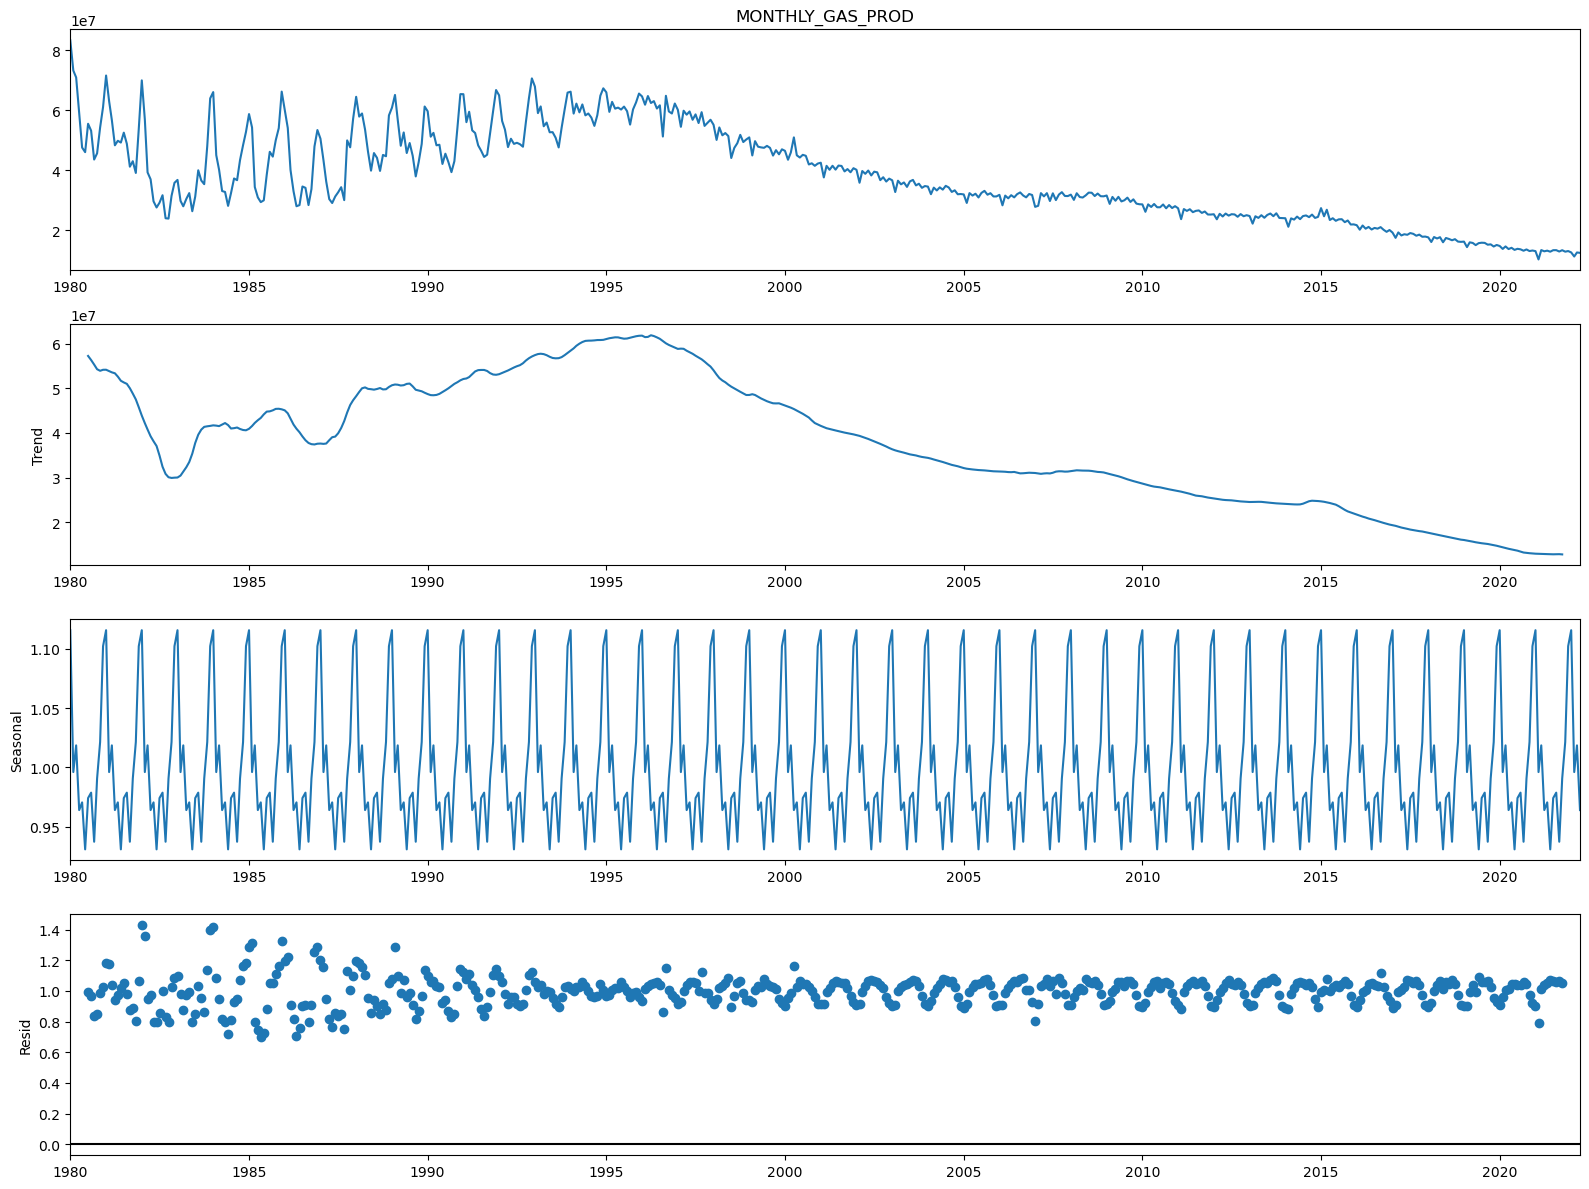

In [9]:
decomposition_mul = seasonal_decompose(df_gas_prod['MONTHLY_GAS_PROD'], period = 12, model = 'multiplicative')
figure = decomposition_mul.plot()
plt.show()

"multiplicative" seasonality did not add much, we stay with "additive" seasonality.

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


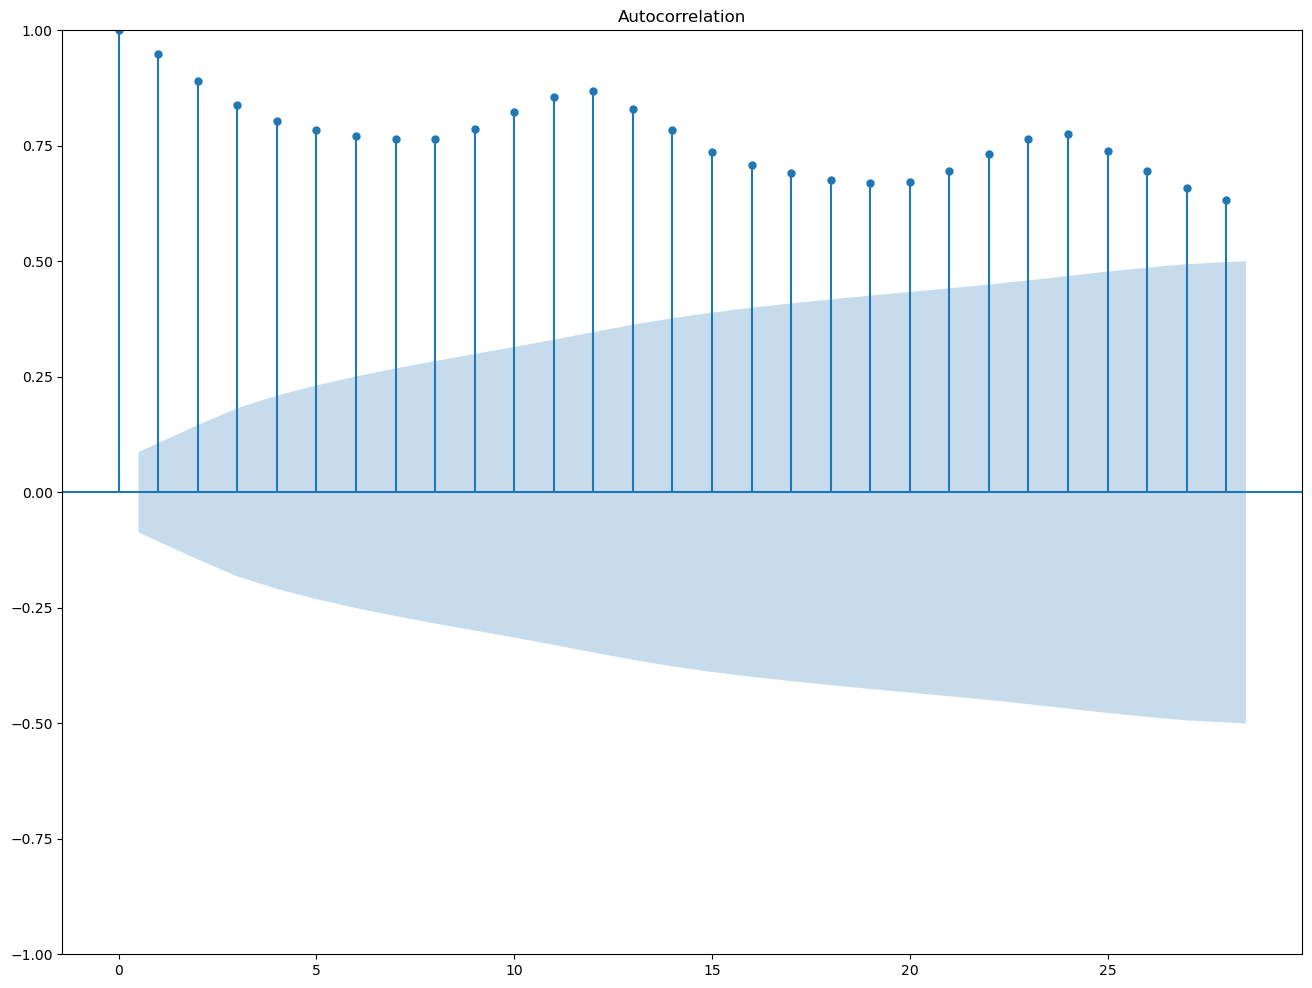

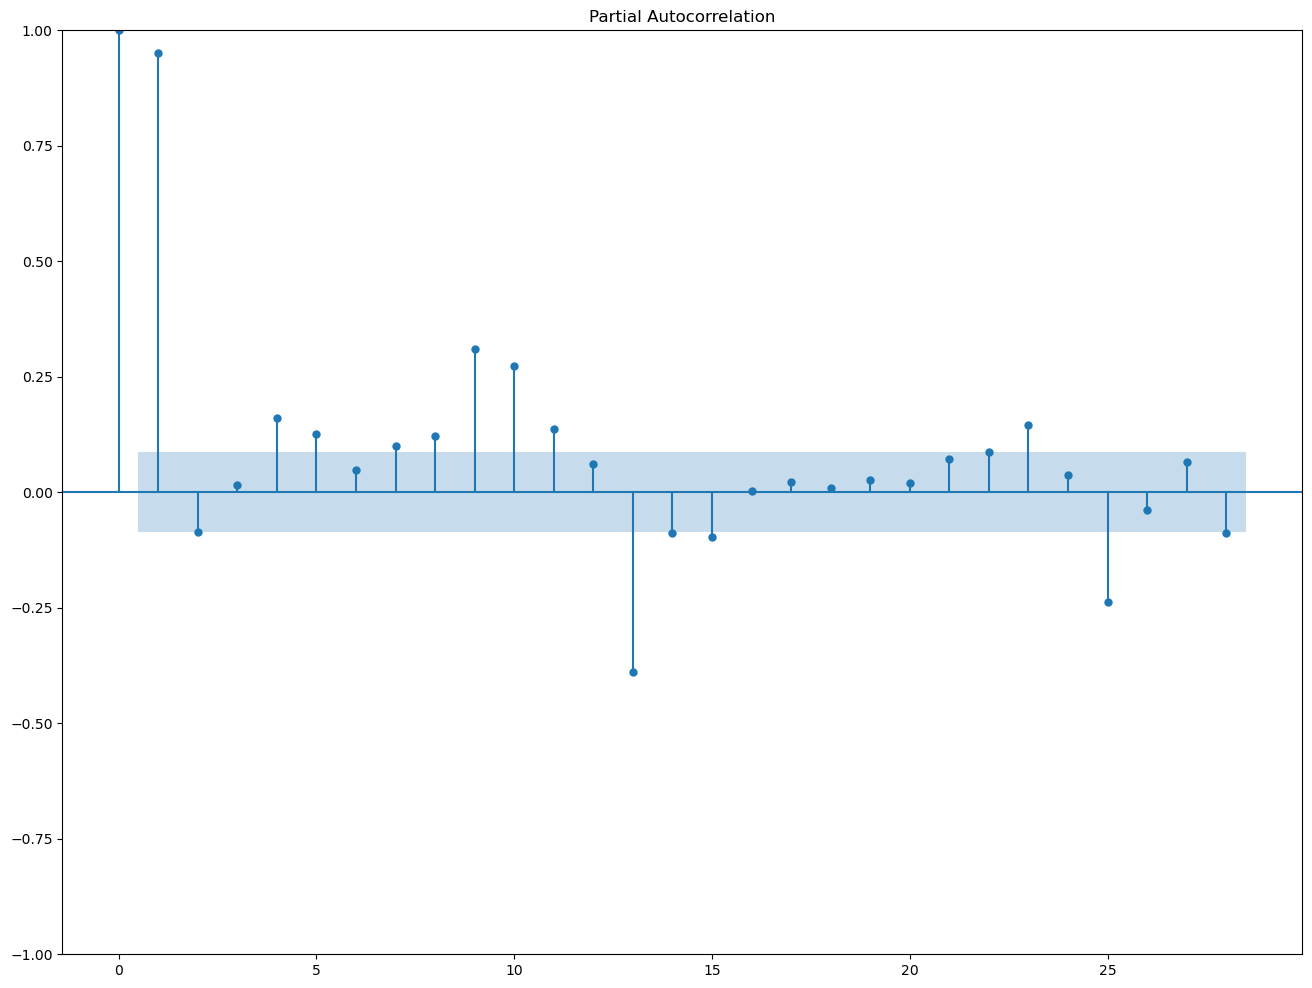

In [10]:
plot_acf(df_gas_prod['MONTHLY_GAS_PROD'])
print()

plot_pacf(df_gas_prod['MONTHLY_GAS_PROD'])
print()

ACF & PACF plots also indicate clear trend and seasonality.

**Stationarity Check - Augmented Dickey-Fuller Test**

In [11]:
# Source - https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def adfuller_test(series, name='', signif=0.05, verbose=False):
    
    """Perform ADFuller to test for Stationarity of given series and print report"""
    
    r = adfuller(series, autolag='AIC')
    
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n" )
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [12]:
adfuller_test(df_gas_prod['MONTHLY_GAS_PROD'], 'MONTHLY_GAS_PROD')

    Augmented Dickey-Fuller Test on "MONTHLY_GAS_PROD" 

 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.8745
 No. Lags Chosen       = 16
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.7962. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


In [13]:
adfuller_test(df_gas_prod['N_WELLS'], 'N_WELLS')

    Augmented Dickey-Fuller Test on "N_WELLS" 

 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3259
 No. Lags Chosen       = 14
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.6173. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


Since data is Non-Stationary, take the difference and re-test for Stationary

In [14]:
# 1st difference
df_diff = df_gas_prod.diff().dropna()
df_diff.head()

N_WELLS  MONTHLY_GAS_PROD
DATE                                 
1980-02-01   -580.0       -10091792.0
1980-03-01    517.0        -2301504.0
1980-04-01   -219.0       -11937257.0
1980-05-01   -276.0       -11462035.0
1980-06-01   -285.0        -1538712.0

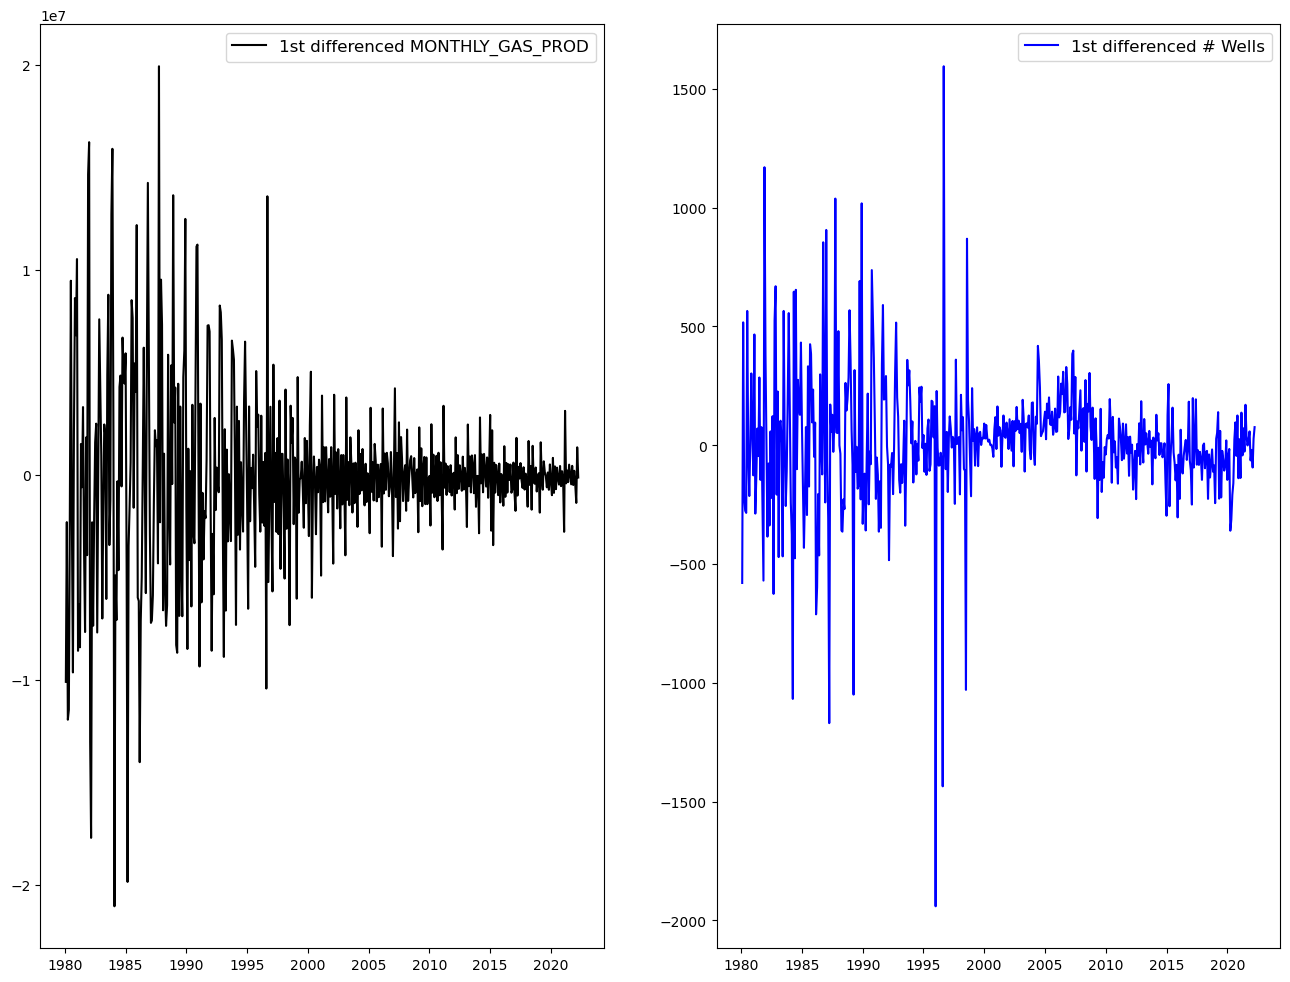

In [15]:
plt.subplot(1, 2, 2)

plt.subplot(1, 2, 1)
plt.plot(df_diff['MONTHLY_GAS_PROD'], color='black', label='1st differenced MONTHLY_GAS_PROD')
plt.legend(loc='upper right', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(df_diff['N_WELLS'], color='blue', label='1st differenced # Wells')
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [16]:
adfuller_test(df_diff['MONTHLY_GAS_PROD'], 'MONTHLY_GAS_PROD')

    Augmented Dickey-Fuller Test on "MONTHLY_GAS_PROD" 

 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7789
 No. Lags Chosen       = 15
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [17]:
adfuller_test(df_diff['N_WELLS'], 'N_WELLS')

    Augmented Dickey-Fuller Test on "N_WELLS" 

 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2236
 No. Lags Chosen       = 13
 Critical value 1%     = -3.444
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0187. Rejecting Null Hypothesis.
 => Series is Stationary.


**Granger’s causality tests**

In [18]:
# data for test whether the time series in the second column Granger causes the time series in the first column
print('N_WELLS causes MONTHLY_GAS_PROD?\n')
granger_1 = grangercausalitytests(df_gas_prod[['MONTHLY_GAS_PROD', 'N_WELLS']], maxlag=3)

N_WELLS causes MONTHLY_GAS_PROD?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6658 , p=0.0004  , df_denom=504, df_num=1
ssr based chi2 test:   chi2=12.7411 , p=0.0004  , df=1
likelihood ratio test: chi2=12.5837 , p=0.0004  , df=1
parameter F test:         F=12.6658 , p=0.0004  , df_denom=504, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.2042 , p=0.0000  , df_denom=501, df_num=2
ssr based chi2 test:   chi2=20.6121 , p=0.0000  , df=2
likelihood ratio test: chi2=20.2034 , p=0.0000  , df=2
parameter F test:         F=10.2042 , p=0.0000  , df_denom=501, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.7347  , p=0.0002  , df_denom=498, df_num=3
ssr based chi2 test:   chi2=20.4880 , p=0.0001  , df=3
likelihood ratio test: chi2=20.0833 , p=0.0002  , df=3
parameter F test:         F=6.7347  , p=0.0002  , df_denom=498, df_num=3


Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero that is past values of one time series data do not cause the other time series.

For 95% CI, if p-value is less than 0.05, can reject the null hypothesis.

Here p-value is less than 0.05 for lag 1, 2 and even 3, so N_WELLS causes MONTHLY_GAS_PROD.

In [19]:
# data for test whether the time series in the second column Granger causes the time series in the first column
print('MONTHLY_GAS_PROD causes N_WELLS?\n')
granger_2 = grangercausalitytests(df_gas_prod[['N_WELLS', 'MONTHLY_GAS_PROD']], maxlag=3)

MONTHLY_GAS_PROD causes N_WELLS?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3051  , p=0.0217  , df_denom=504, df_num=1
ssr based chi2 test:   chi2=5.3367  , p=0.0209  , df=1
likelihood ratio test: chi2=5.3088  , p=0.0212  , df=1
parameter F test:         F=5.3051  , p=0.0217  , df_denom=504, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.6696  , p=0.0002  , df_denom=501, df_num=2
ssr based chi2 test:   chi2=17.5122 , p=0.0002  , df=2
likelihood ratio test: chi2=17.2159 , p=0.0002  , df=2
parameter F test:         F=8.6696  , p=0.0002  , df_denom=501, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.0388  , p=0.0000  , df_denom=498, df_num=3
ssr based chi2 test:   chi2=24.4554 , p=0.0000  , df=3
likelihood ratio test: chi2=23.8817 , p=0.0000  , df=3
parameter F test:         F=8.0388  , p=0.0000  , df_denom=498, df_num=3


Even though Granger Causality indicates MONTHLY_GAS_PROD causes N_WELLS which is not totally logical. Lets start with Univariate time series models.

**Train & Test Split**

In [20]:
# 36 months of data is used as test data
test_obs = 36

xtrain, xvalid = model_selection.train_test_split(df_gas_prod, test_size = test_obs)
print(xtrain.shape, xvalid.shape)

(472, 2) (36, 2)


**Exponential Smoothing (Triple Exponential Smoothing) Model** - smoothed series is a simple weighted average of the past and the present

In [21]:
fit1 = ExponentialSmoothing(xtrain['MONTHLY_GAS_PROD'].values, seasonal_periods = 12, trend = 'add', seasonal = 'add', 
                            use_boxcox=True)
fit1 = fit1.fit()

In [22]:
fit1.params_formatted

name        param  optimized
smoothing_level     alpha     0.499854       True
smoothing_trend      beta     0.000100       True
smoothing_seasonal  gamma     0.324996       True
initial_level         l.0  1018.831199       True
initial_trend         b.0    -0.713366       True
initial_seasons.0     s.0   120.405134       True
initial_seasons.1     s.1    47.848036       True
initial_seasons.2     s.2    -1.633793       True
initial_seasons.3     s.3   -26.798520       True
initial_seasons.4     s.4   -35.781003       True
initial_seasons.5     s.5   -64.948648       True
initial_seasons.6     s.6   -19.532381       True
initial_seasons.7     s.7    -2.927589       True
initial_seasons.8     s.8   -53.171646       True
initial_seasons.9     s.9   -45.194357       True
initial_seasons.10   s.10     5.816671       True
initial_seasons.11   s.11    75.954229       True

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


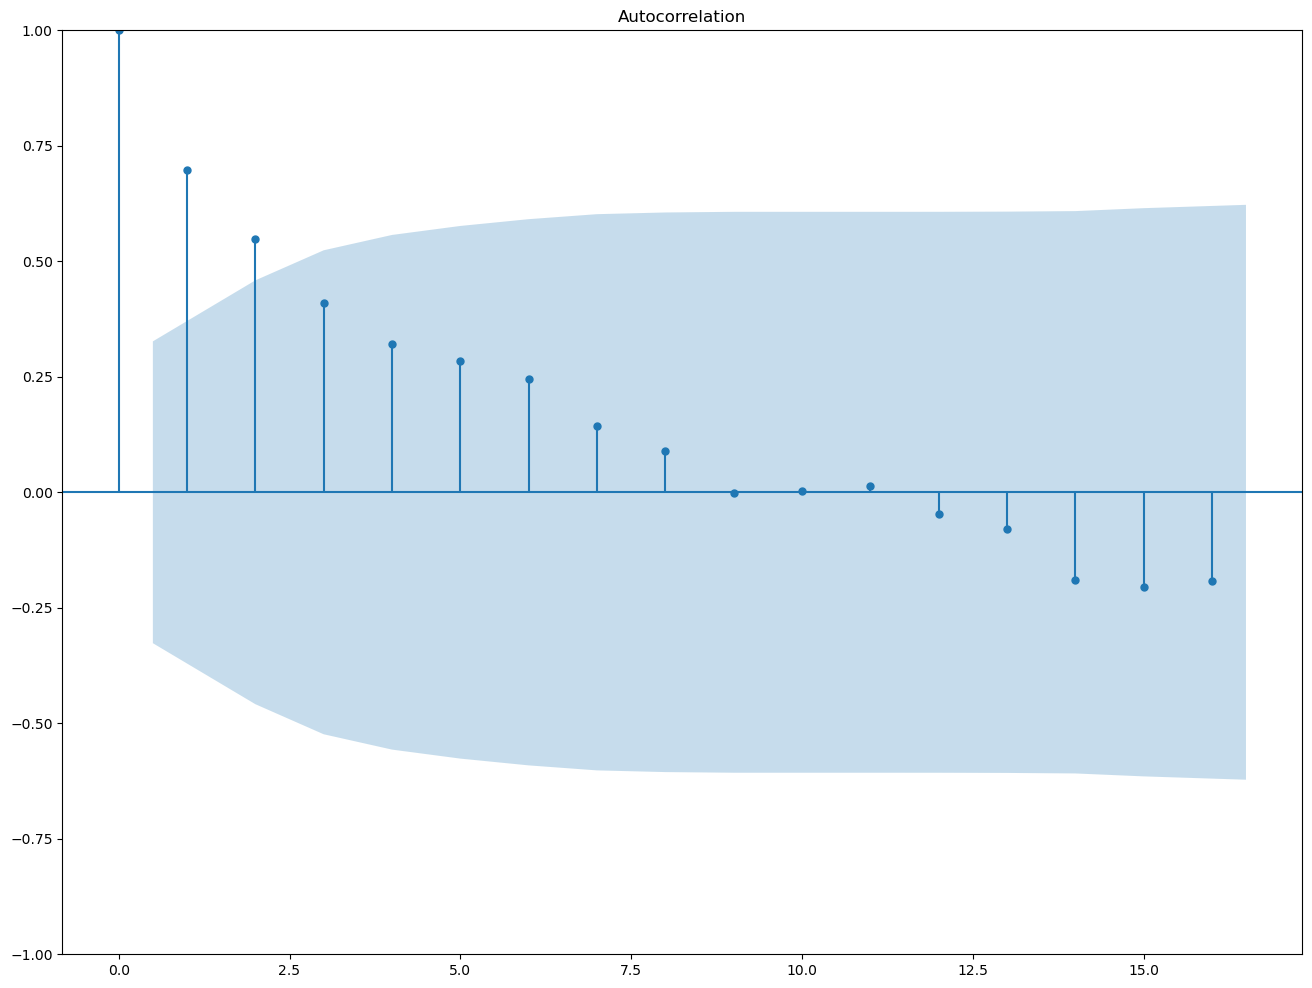

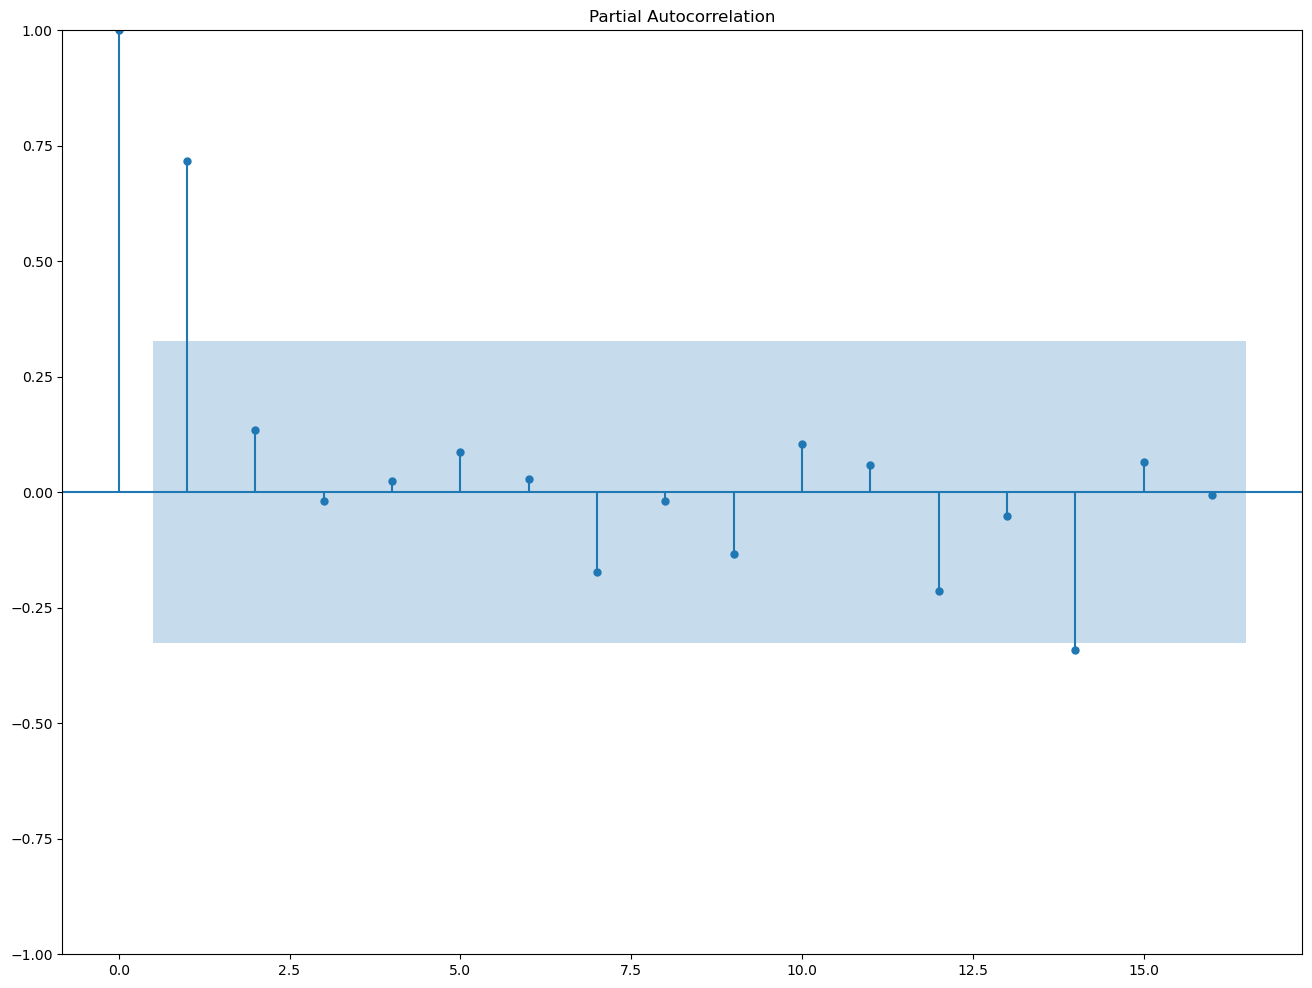

In [23]:
prediction_hw = fit1.forecast(len(xvalid)).copy()

xresiduals = xvalid['MONTHLY_GAS_PROD'] - prediction_hw
plot_acf(xresiduals)
print()

plot_pacf(xresiduals)
print()

Some lags are outside of 95% confidence band.

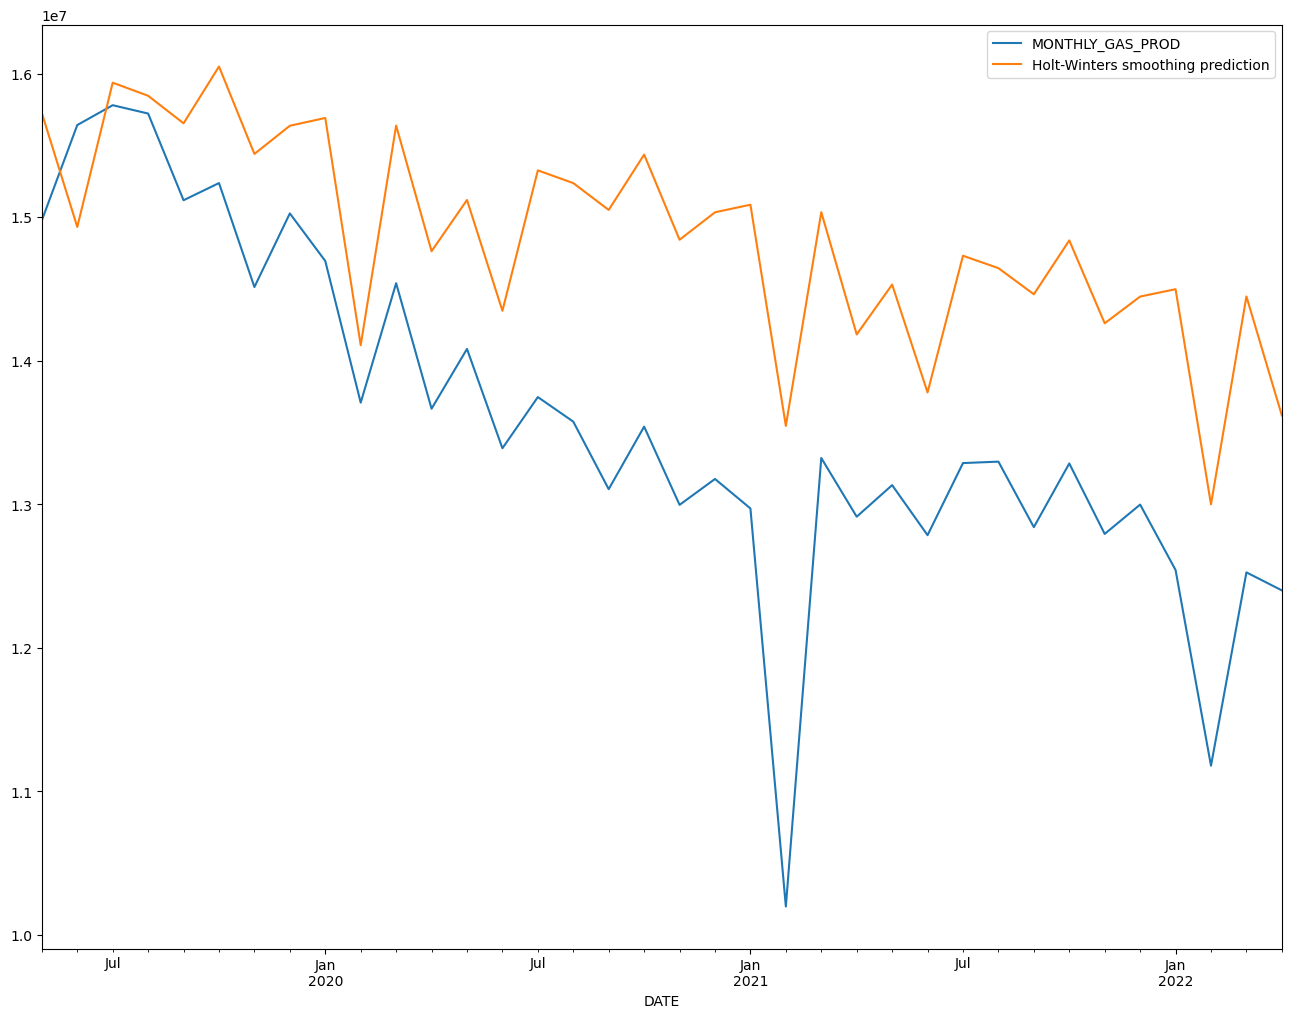

In [24]:
pd.DataFrame({'MONTHLY_GAS_PROD':xvalid['MONTHLY_GAS_PROD'],'Holt-Winters smoothing prediction':prediction_hw}).plot()
plt.show()

Exponential Smoothing did a decent job in capturing the trend but overall prediction is higher than the actual.

Since there is seaonality, lets try SARIMA

**SARIMA (Seasonal ARIMA) Model**

In [25]:
model_sarima = auto_arima(xtrain['MONTHLY_GAS_PROD'], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15258.412, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15178.108, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=15153.506, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=15246.798, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=15148.397, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=15174.432, Time=0.31 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=15147.234, Time=1.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=15166.597, Time=0.73 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=15148.362, Time=2.41 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=15148.033, Time=1.70 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=15172.446, Time=1.94 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=15144.377, Time=2.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=15144.721, Time=0.90 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=15165.800, Time=2.10 sec
 ARIM

In [26]:
print(model_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  472
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -7566.188
Date:                            Wed, 16 Nov 2022   AIC                          15144.377
Time:                                    19:04:54   BIC                          15169.151
Sample:                                01-01-1980   HQIC                         15154.133
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5582      0.139      4.025      0.000       0.286       0.830
ma.L1         -0.6770      0.124   

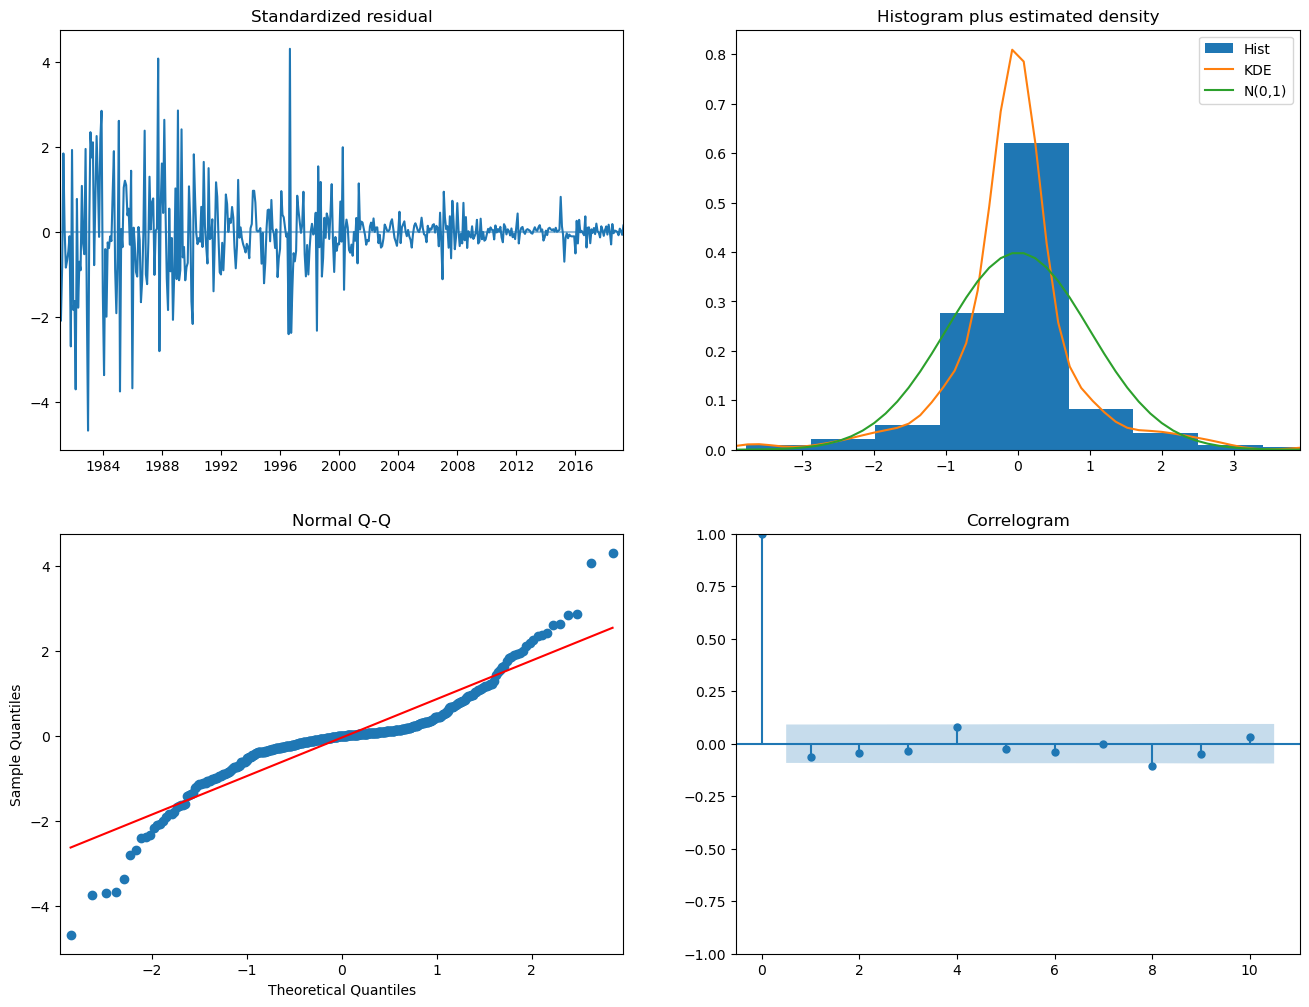

In [27]:
model_sarima.plot_diagnostics()
plt.show()

Residuals are almost symmetrical around zero and do not show heteroscedasticity. Normal Q-Q plot show tails and no lags are outside of 95% confidence band in ACF plot. Overall SARIMA is a decent fit.

In [28]:
fitted, confint = model_sarima.predict(xvalid['MONTHLY_GAS_PROD'].shape[0], return_conf_int=True, alpha=0.05)
lower_conf = pd.Series(confint[:, 0], index=xvalid.index)
lower_conf[lower_conf < 0] = 0
upper_conf = pd.Series(confint[:, 1], index=xvalid.index)

hw_pred = pd.Series(prediction_hw, index=xvalid.index)

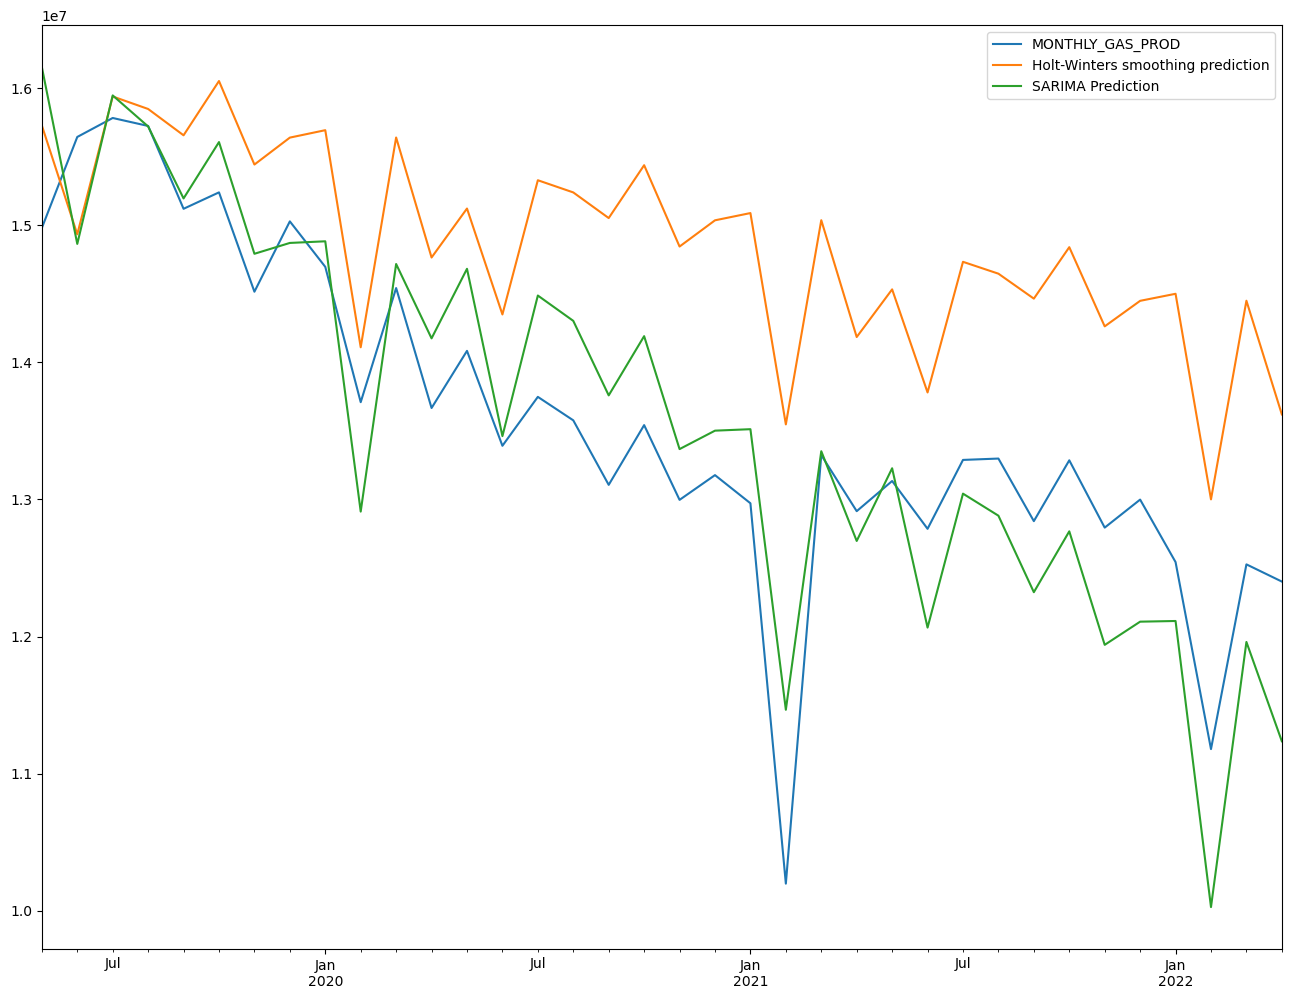

In [29]:
pd.DataFrame({'MONTHLY_GAS_PROD':xvalid['MONTHLY_GAS_PROD'],
              'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted}).plot()
plt.show()

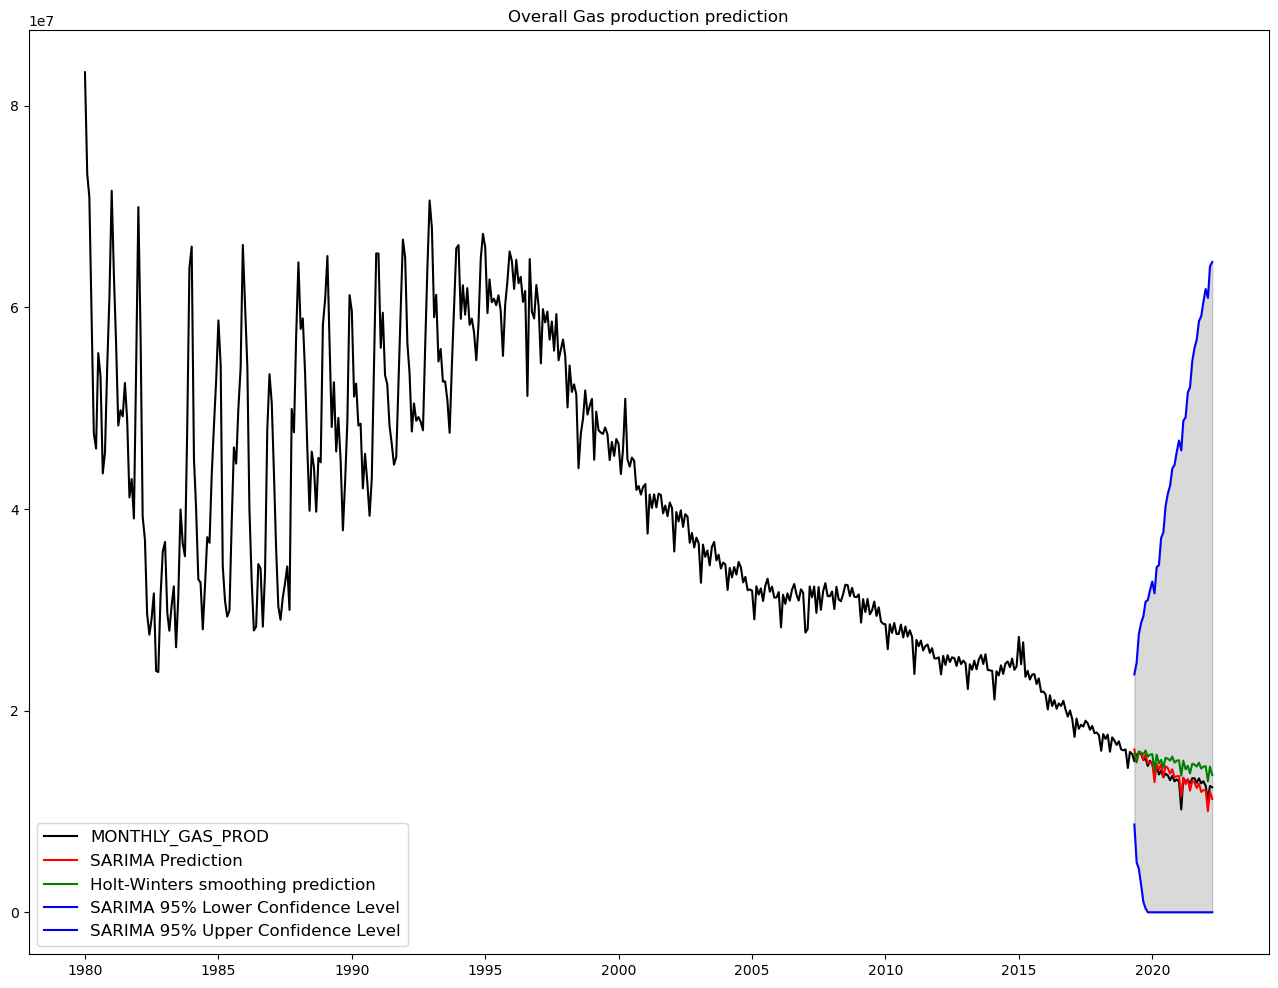

In [30]:
plt.plot(df_gas_prod['MONTHLY_GAS_PROD'], color='black', label='MONTHLY_GAS_PROD')
plt.plot(pd.Series(fitted), color='red', label='SARIMA Prediction')
plt.plot(hw_pred, color='green', label='Holt-Winters smoothing prediction')
plt.plot(lower_conf, color='blue', label='SARIMA 95% Lower Confidence Level')
plt.plot(upper_conf, color='blue', label='SARIMA 95% Upper Confidence Level')
plt.fill_between(lower_conf.index, 
                 lower_conf, 
                 upper_conf, 
                 color='k', alpha=.15)
plt.title('Overall Gas production prediction')
plt.legend(loc='lower left', fontsize=12)
plt.show()

**SARIMAX (Seasonal ARIMA with Exogeneous Time Series)**

number of wells used as exogeneous predictor

In [31]:
model_sarimax = auto_arima(xtrain['MONTHLY_GAS_PROD'], X= xtrain[['N_WELLS']], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=17511.728, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15055.676, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=15010.442, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=15140.198, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=15011.406, Time=0.52 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=15011.573, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=15048.412, Time=0.42 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=15007.882, Time=0.28 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=15008.411, Time=0.34 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=15033.485, Time=0.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=15055.438, Time=0.22 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=3.84 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=15016.669, Time=0.31 sec
 ARIMA(1,1,1)(0,1

In [32]:
print(model_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  472
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -7497.594
Date:                            Wed, 16 Nov 2022   AIC                          15005.189
Time:                                    19:05:17   BIC                          15025.834
Sample:                                01-01-1980   HQIC                         15013.319
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
N_WELLS     5263.6973    294.105     17.897      0.000    4687.262    5840.133
ar.L1          0.5906      0.124   

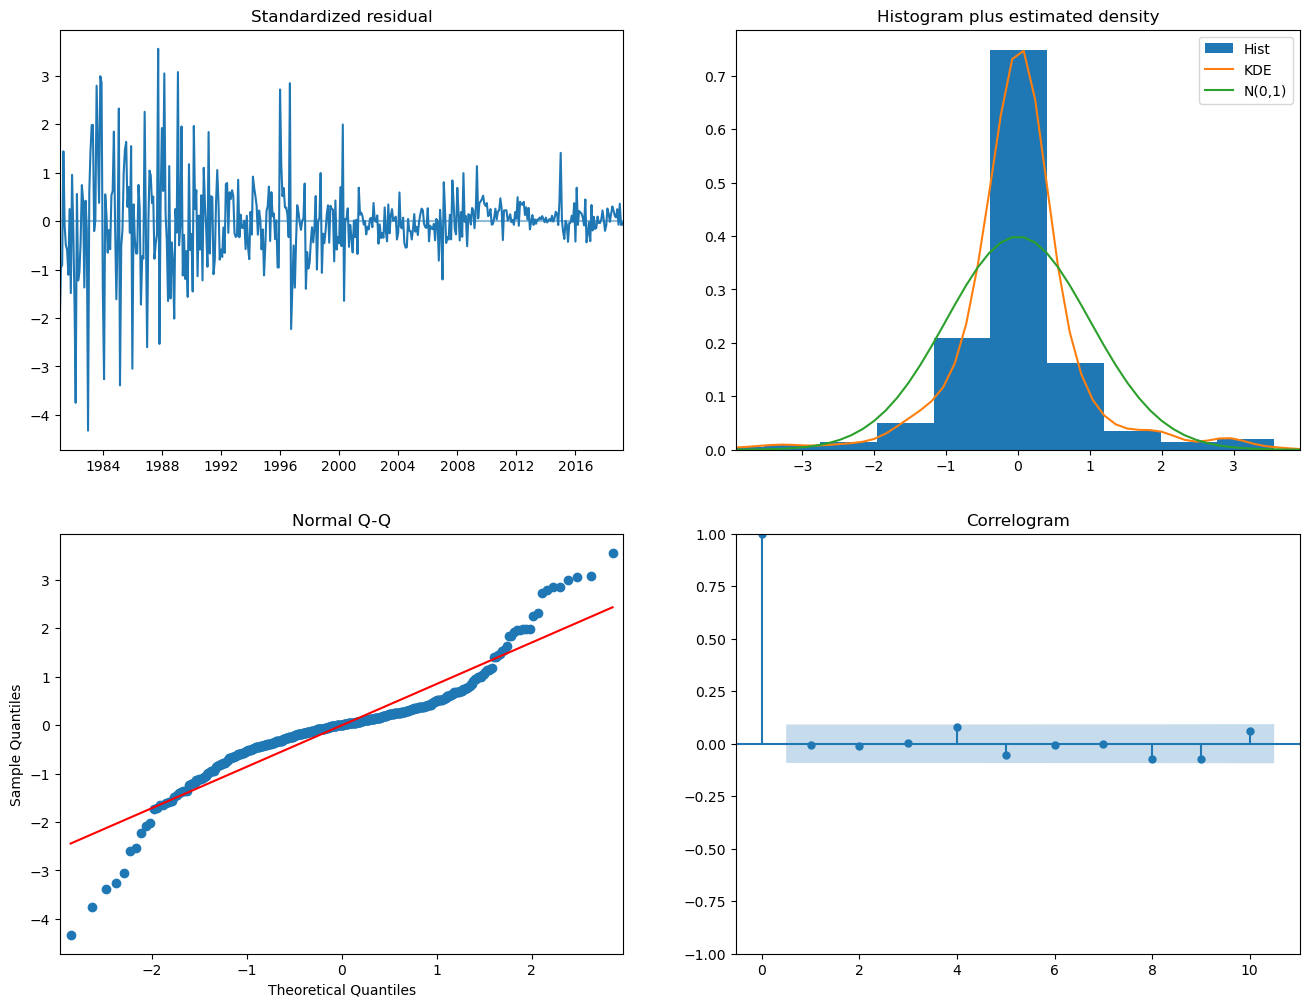

In [33]:
model_sarimax.plot_diagnostics()
plt.show()

In [34]:
fittedx, confintx = model_sarimax.predict(xvalid['MONTHLY_GAS_PROD'].shape[0], X = xvalid[['N_WELLS']], 
                                          return_conf_int=True, alpha=0.05)
lower_confx = pd.Series(confintx[:, 0], index=xvalid.index)
lower_confx[lower_confx < 0] = 0
upper_confx = pd.Series(confintx[:, 1], index=xvalid.index)

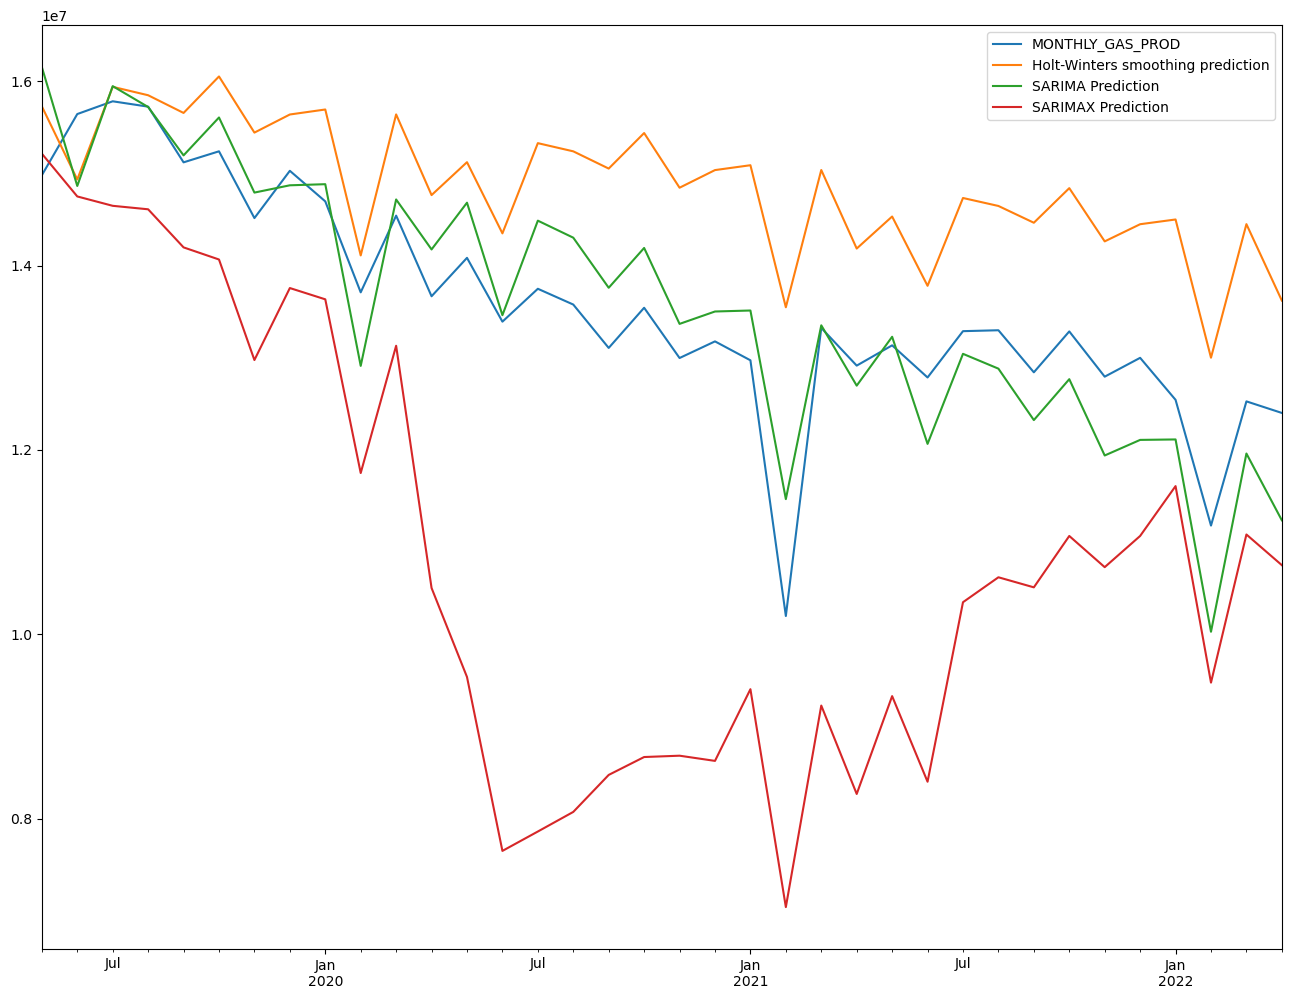

In [35]:
pd.DataFrame({'MONTHLY_GAS_PROD':xvalid['MONTHLY_GAS_PROD'],
              'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted,
              'SARIMAX Prediction':fittedx}).plot()
plt.show()

In [36]:
plt_df = pd.DataFrame({'MONTHLY_GAS_PROD':xvalid['MONTHLY_GAS_PROD'],
              'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted,
              'SARIMAX Prediction':fittedx})
plt_df

MONTHLY_GAS_PROD  Holt-Winters smoothing prediction  \
2019-05-01        14979209.0                       1.572626e+07   
2019-06-01        15642876.0                       1.493309e+07   
2019-07-01        15781224.0                       1.593812e+07   
2019-08-01        15723079.0                       1.584691e+07   
2019-09-01        15119047.0                       1.565495e+07   
2019-10-01        15238810.0                       1.605073e+07   
2019-11-01        14514424.0                       1.544169e+07   
2019-12-01        15027317.0                       1.563809e+07   
2020-01-01        14695734.0                       1.569230e+07   
2020-02-01        13708999.0                       1.410942e+07   
2020-03-01        14541123.0                       1.563896e+07   
2020-04-01        13666485.0                       1.476390e+07   
2020-05-01        14083041.0                       1.512093e+07   
2020-06-01        13390996.0                       1.434866e+07   
2020-07-01        13747676.0                       1.532726e+07   
2020-08-01        13576515.0                       1.523843e+07   
2020-09-01        13106043.0                       1.505148e+07   
2020-10-01        13541754.0                       1.543695e+07   
2020-11-01        12996630.0                       1.484382e+07   
2020-12-01        13177073.0                       1.503507e+07   
2021-01-01        12971751.0                       1.508786e+07   
2021-02-01        10198215.0                       1.354708e+07   
2021-03-01        13323235.0                       1.503591e+07   
2021-04-01        12914199.0                       1.418397e+07   
2021-05-01        13134151.0                       1.453152e+07   
2021-06-01        12785487.0                       1.377986e+07   
2021-07-01        13287905.0                       1.473240e+07   
2021-08-01        13297821.0                       1.464592e+07   
2021-09-01        12841472.0                       1.446391e+07   
2021-10-01        13285111.0                       1.483920e+07   
2021-11-01        12794294.0                       1.426176e+07   
2021-12-01        12998612.0                       1.444793e+07   
2022-01-01        12542910.0                       1.449932e+07   
2022-02-01        11179210.0                       1.300005e+07   
2022-03-01        12526289.0                       1.444875e+07   
2022-04-01        12400866.0                       1.361961e+07   

            SARIMA Prediction  SARIMAX Prediction  
2019-05-01       1.615242e+07        1.521318e+07  
2019-06-01       1.486295e+07        1.474920e+07  
2019-07-01       1.594574e+07        1.464758e+07  
2019-08-01       1.571942e+07        1.460980e+07  
2019-09-01       1.519459e+07        1.419670e+07  
2019-10-01       1.560558e+07        1.406522e+07  
2019-11-01       1.479103e+07        1.297470e+07  
2019-12-01       1.487009e+07        1.375558e+07  
2020-01-01       1.488204e+07        1.363327e+07  
2020-02-01       1.291120e+07        1.174910e+07  
2020-03-01       1.471643e+07        1.312957e+07  
2020-04-01       1.417429e+07        1.050212e+07  
2020-05-01       1.468145e+07        9.536985e+06  
2020-06-01       1.346139e+07        7.650378e+06  
2020-07-01       1.448657e+07        7.860626e+06  
2020-08-01       1.430187e+07        8.073171e+06  
2020-09-01       1.375856e+07        8.474562e+06  
2020-10-01       1.419038e+07        8.668619e+06  
2020-11-01       1.336683e+07        8.682999e+06  
2020-12-01       1.350126e+07        8.626667e+06  
2021-01-01       1.351197e+07        9.404283e+06  
2021-02-01       1.146603e+07        7.041011e+06  
2021-03-01       1.335127e+07        9.226770e+06  
2021-04-01       1.269705e+07        8.267876e+06  
2021-05-01       1.322703e+07        9.329246e+06  
2021-06-01       1.206526e+07        8.400620e+06  
2021-07-01       1.304193e+07        1.034788e+07  
2021-08-01       1.288121e+07        1.061832e+07  
2021-09-01       1.23233

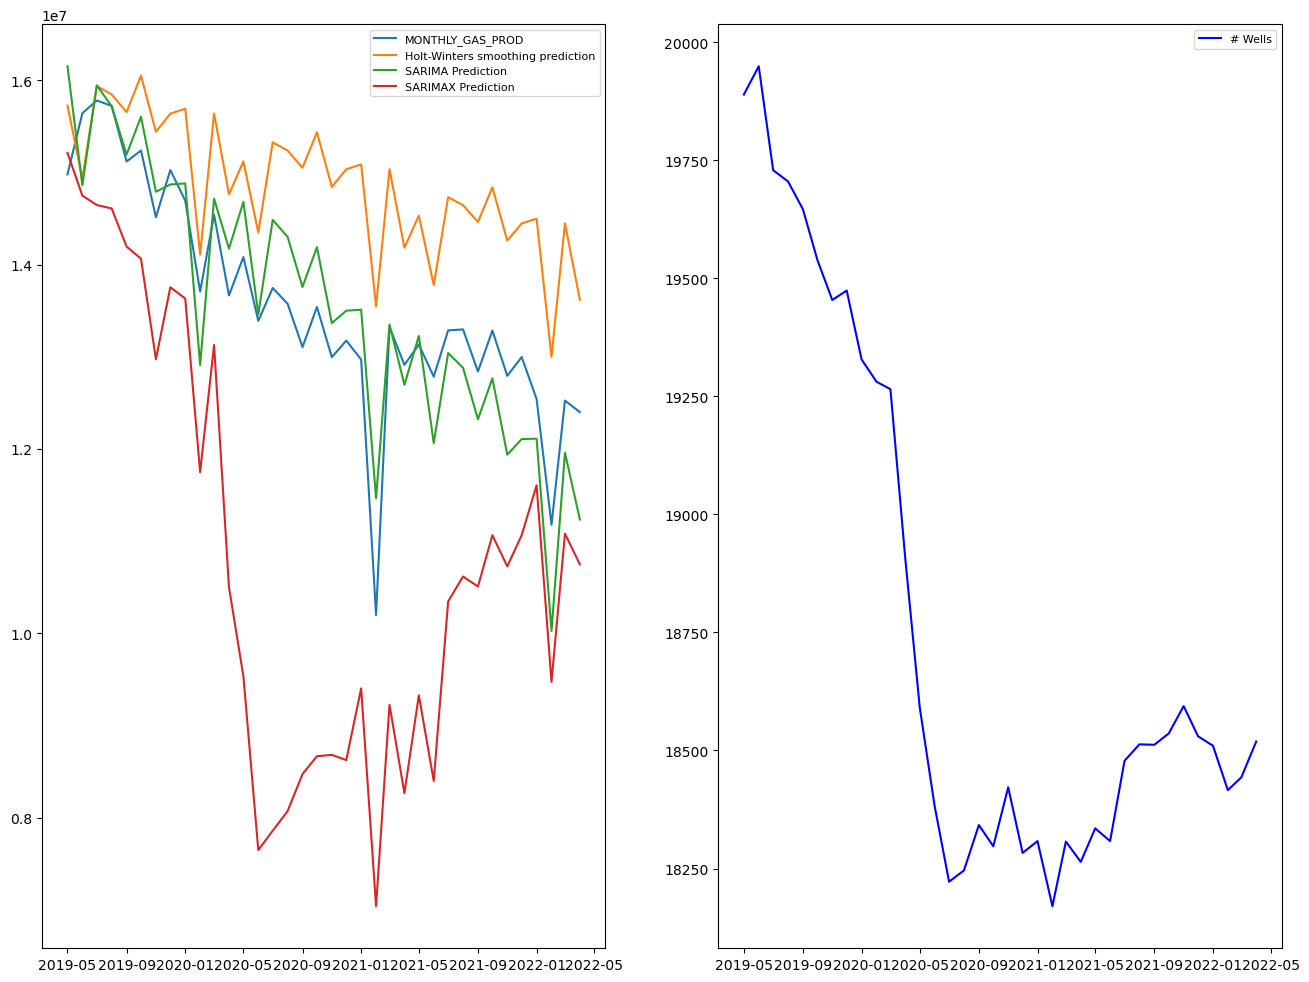

In [37]:
plt.subplot(1, 2, 2)

plt.subplot(1, 2, 1)
for i, c in enumerate(plt_df):
    plt.plot(plt_df[c], label=c)
plt.legend(loc='upper right', fontsize=8)

plt.subplot(1, 2, 2)
plt.plot(xvalid['N_WELLS'], color='blue', label='# Wells')
plt.legend(loc='upper right', fontsize=8)
plt.show()

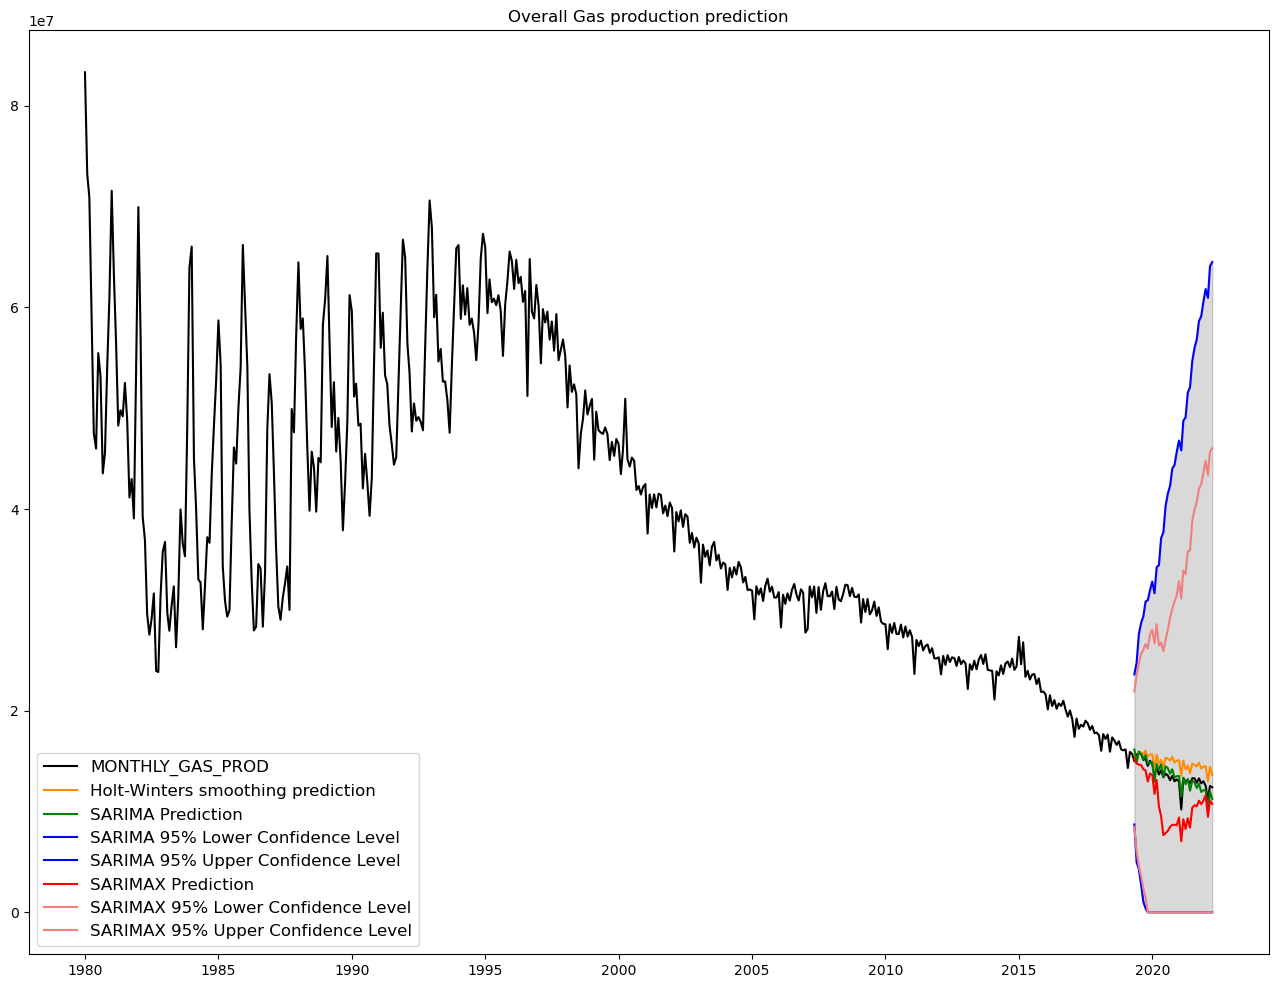

In [38]:
plt.plot(df_gas_prod['MONTHLY_GAS_PROD'], color='black', label='MONTHLY_GAS_PROD')

plt.plot(hw_pred, color='darkorange', label='Holt-Winters smoothing prediction')

plt.plot(pd.Series(fitted), color='green', label='SARIMA Prediction')
plt.plot(lower_conf, color='blue', label='SARIMA 95% Lower Confidence Level')
plt.plot(upper_conf, color='blue', label='SARIMA 95% Upper Confidence Level')

plt.plot(pd.Series(fittedx), color='red', label='SARIMAX Prediction')
plt.plot(lower_confx, color='lightcoral', label='SARIMAX 95% Lower Confidence Level')
plt.plot(upper_confx, color='lightcoral', label='SARIMAX 95% Upper Confidence Level')


plt.fill_between(lower_conf.index, 
                 lower_conf, 
                 upper_conf, 
                 color='k', alpha=.15)
plt.title('Overall Gas production prediction')
plt.legend(loc='lower left', fontsize=12)
plt.show()

SARIMA performed better than SARIMAX for Gas Production prediction.

According to the domain expert, production should change as number of wells change which we are not seeing in gas production. As a result, SARIMAX which uses number of wells as one of the predictors did not perform well as gas production didn’t drop according to number of wells, and hence SARIMA is doing much better. To confirm model choices, lets do 5-fold cross validation or what we call as Walk Forward Validation for time series data.

**Walk Forward Validation via TimeSeriesSplit**

Observations: 160
Training Observations: 82
Testing Observations: 78
Observations: 238
Training Observations: 160
Testing Observations: 78
Observations: 316
Training Observations: 238
Testing Observations: 78
Observations: 394
Training Observations: 316
Testing Observations: 78
Observations: 472
Training Observations: 394
Testing Observations: 78


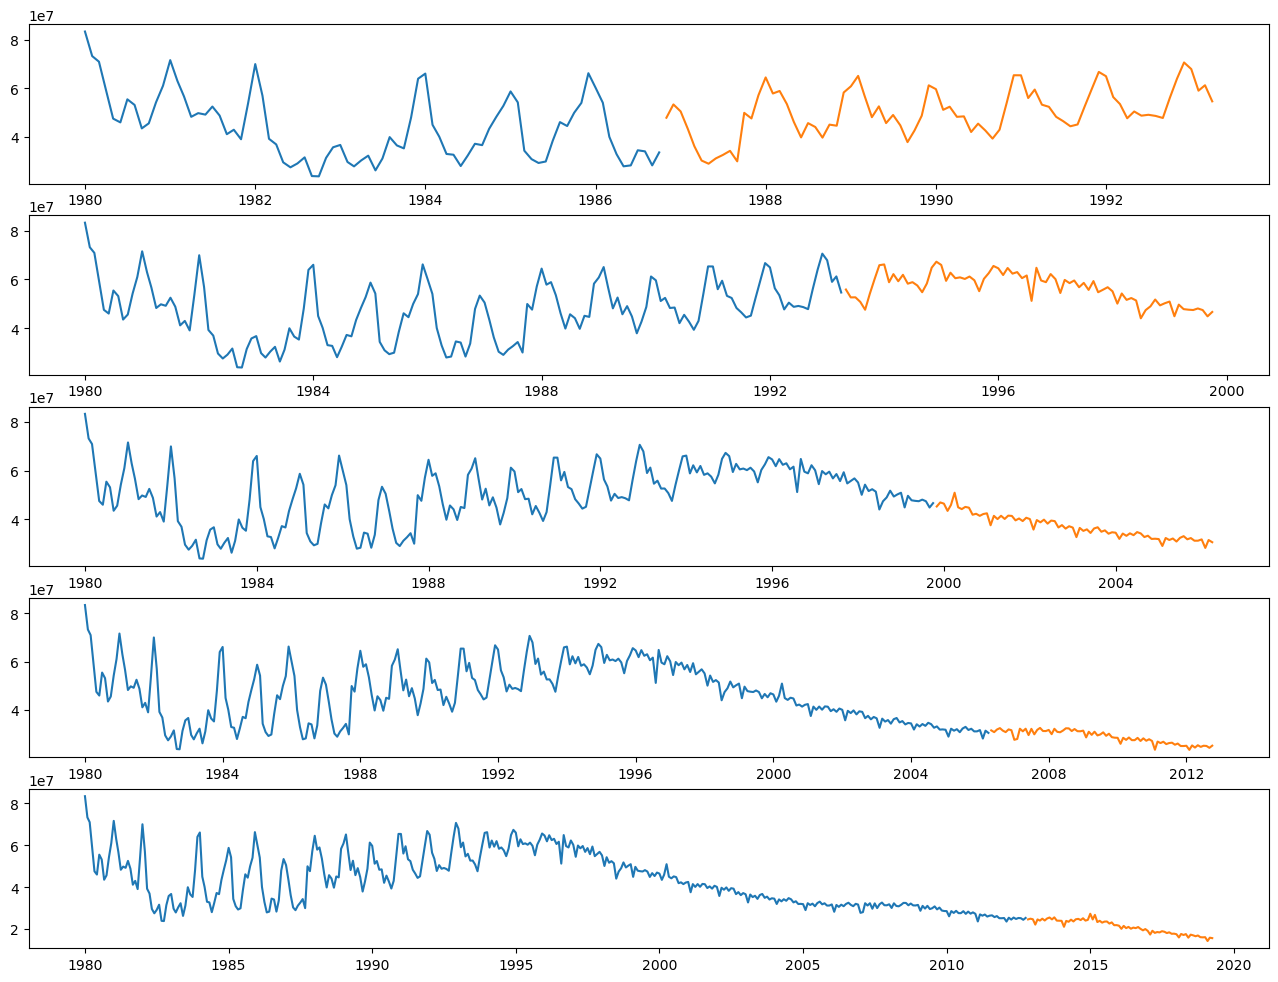

In [39]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

plt.figure(1)
index = 1
for train_index, test_index in tscv.split(xtrain):
	train_cv = xtrain.iloc[train_index,:]
	test_cv = xtrain.iloc[test_index, :]
	print('Observations: %d' % (len(train_cv) + len(test_cv)))
	print('Training Observations: %d' % (len(train_cv)))
	print('Testing Observations: %d' % (len(test_cv)))
	plt.subplot(510 + index)
	plt.plot(train_cv['MONTHLY_GAS_PROD'])
	plt.plot(test_cv['MONTHLY_GAS_PROD'])
	index += 1
plt.show()

**SARIMA with Walk Forward Validation**

 ARIMA(0,1,0)(0,1,1)[12]          
 ARIMA(0,1,0)(1,1,1)[12]          
 ARIMA(1,1,1)(1,1,1)[12]          
 ARIMA(1,1,1)(1,1,1)[12]          
 ARIMA(1,1,1)(1,1,1)[12]          


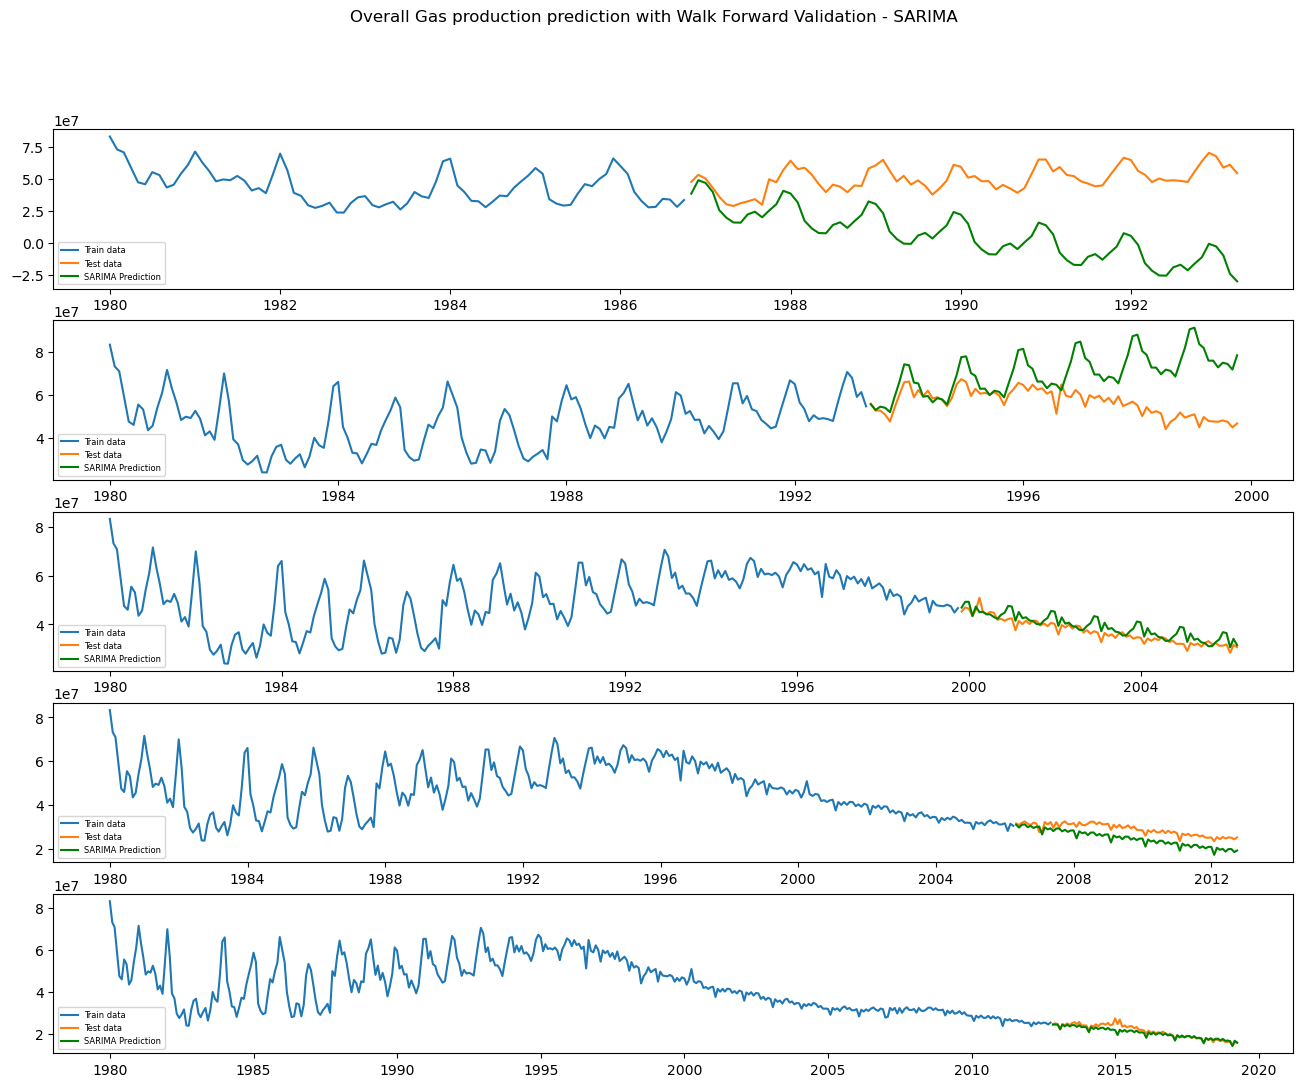

[48784475.832606666, 17757114.730781056, 3191631.6145839123, 4360633.154679229, 1505263.840441177]


In [40]:

plt.figure(1)
index = 1

rmse_sarima_cv = []

for train_index, test_index in tscv.split(xtrain):
	
	train_cv = xtrain.iloc[train_index,:]
	test_cv = xtrain.iloc[test_index, :]


	model_sarima_cv = auto_arima(train_cv['MONTHLY_GAS_PROD'], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=False, error_action='ignore', suppress_warnings=True)
	
	print(model_sarima_cv)
	
	fitted_cv, confint_cv = model_sarima_cv.predict(test_cv['MONTHLY_GAS_PROD'].shape[0], return_conf_int=True, alpha=0.05)
	lower_conf_cv = pd.Series(confint_cv[:, 0], index=fitted_cv.index)
	upper_conf_cv = pd.Series(confint_cv[:, 1], index=fitted_cv.index)


	rmse_sarima_cv.append(np.sqrt(mean_squared_error(fitted_cv, test_cv['MONTHLY_GAS_PROD'])))


	plt.subplot(510 + index)
	plt.plot(train_cv['MONTHLY_GAS_PROD'], label='Train data')
	plt.plot(test_cv['MONTHLY_GAS_PROD'], label='Test data')
	plt.plot(pd.Series(fitted_cv), color='green', label='SARIMA Prediction')
	#plt.plot(lower_conf_cv, color='blue', label='SARIMA 95% Lower Confidence Level')
	#plt.plot(upper_conf_cv, color='blue', label='SARIMA 95% Upper Confidence Level')
	plt.legend(loc='lower left', fontsize=6)

	index += 1

plt.suptitle('Overall Gas production prediction with Walk Forward Validation - SARIMA')
plt.show()


print(rmse_sarima_cv)

**SARIMAX with Walk Forward Validation**

 ARIMA(0,1,0)(1,1,1)[12]          
 ARIMA(0,1,0)(0,1,2)[12]          
 ARIMA(0,1,0)(0,1,1)[12]          
 ARIMA(0,1,0)(0,1,1)[12]          
 ARIMA(1,1,1)(0,1,1)[12]          


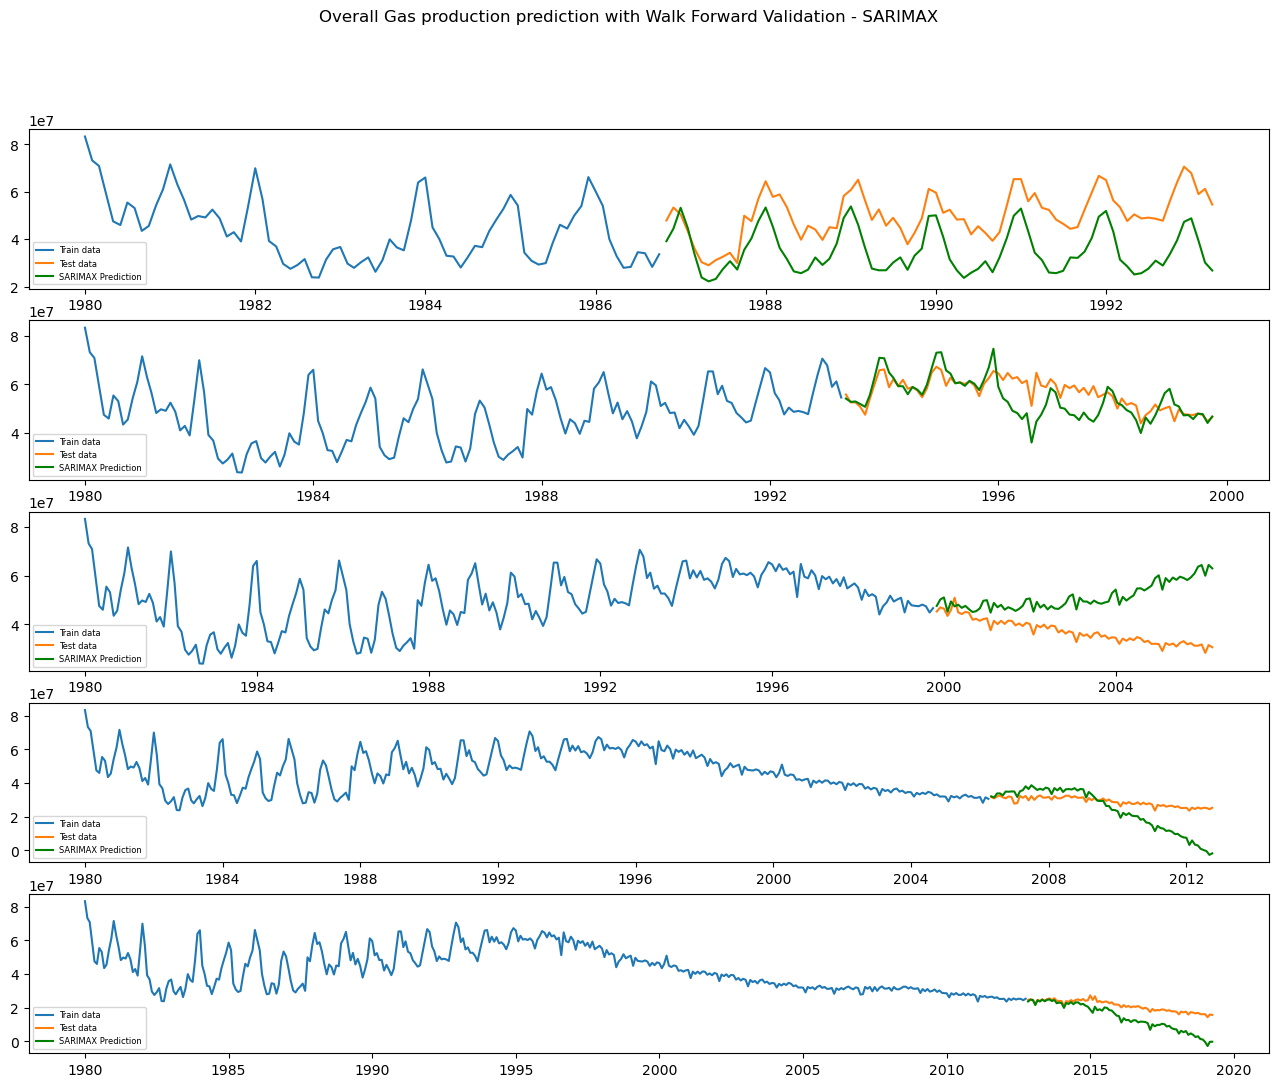

[16732513.731886568, 6716970.664438563, 16994670.176576585, 11066828.203485249, 8282408.513064912]


In [41]:

plt.figure(1)
index = 1

rmse_sarimax_cv = []

for train_index, test_index in tscv.split(xtrain):
	
	train_cv = xtrain.iloc[train_index,:]
	test_cv = xtrain.iloc[test_index, :]


	model_sarimax_cv = auto_arima(train_cv['MONTHLY_GAS_PROD'], X= train_cv[['N_WELLS']], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=False, error_action='ignore', suppress_warnings=True)

	print(model_sarimax_cv)

	fittedx_cv, confintx_cv = model_sarimax_cv.predict(test_cv['MONTHLY_GAS_PROD'].shape[0], X = test_cv[['N_WELLS']], 
											return_conf_int=True, alpha=0.05)
	lower_confx_cv = pd.Series(confintx_cv[:, 0], index=fittedx_cv.index)
	upper_confx_cv = pd.Series(confintx_cv[:, 1], index=fittedx_cv.index)	
	
	rmse_sarimax_cv.append(np.sqrt(mean_squared_error(fittedx_cv, test_cv['MONTHLY_GAS_PROD'])))


	plt.subplot(510 + index)
	plt.plot(train_cv['MONTHLY_GAS_PROD'], label='Train data')
	plt.plot(test_cv['MONTHLY_GAS_PROD'], label='Test data')
	plt.plot(pd.Series(fittedx_cv), color='green', label='SARIMAX Prediction')
	#plt.plot(lower_conf_cv, color='blue', label='SARIMA 95% Lower Confidence Level')
	#plt.plot(upper_conf_cv, color='blue', label='SARIMA 95% Upper Confidence Level')
	plt.legend(loc='lower left', fontsize=6)

	index += 1

plt.suptitle('Overall Gas production prediction with Walk Forward Validation - SARIMAX')
plt.show()


print(rmse_sarimax_cv)

**VAR model**

Though VAR model does not make mcuh sense here, tried just to compare the performance.

In [42]:
# Split differenced data into train and test
xtrain_d, xvalid_d = model_selection.train_test_split(df_diff, test_size = test_obs)
print(xtrain_d.shape, xvalid_d.shape)

(471, 2) (36, 2)


In [43]:
model_var = VAR(xtrain_d, freq='MS')
model_ord = model_var.select_order(maxlags=20)
model_ord.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [44]:
model_varx = VARMAX(xtrain, order=(16, 0), freq='MS', enforce_stationarity= True)

fitted_model = model_varx.fit(disp=False)
print(fitted_model.summary())

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  Statespace Model Results                                 
Dep. Variable:     ['N_WELLS', 'MONTHLY_GAS_PROD']   No. Observations:                  472
Model:                                     VAR(16)   Log Likelihood              -10947.230
                                       + intercept   AIC                          22032.459
Date:                             Wed, 16 Nov 2022   BIC                          22319.291
Time:                                     19:07:54   HQIC                         22145.286
Sample:                                 01-01-1980                                         
                                      - 04-01-2019                                         
Covariance Type:                               opg                                         
Ljung-Box (L1) (Q):             0.03, 0.02   Jarque-Bera (JB):      2653.50, 192.02
Prob(Q):                        0.86, 0.88   Prob(JB):                   0.00, 0.00
Hete

In [45]:
n_forecast = test_obs
#start="2022-10-01",end='2023-01-01')
var_predict = fitted_model.get_prediction(start=len(xtrain), end=len(xtrain) + n_forecast-1)

var_predictions = var_predict.predicted_mean
var_predictions.columns=['NWELLS_predicted', 'MONTHLY_GAS_PROD_predicted']

var_CI = var_predict.conf_int(alpha=0.05)

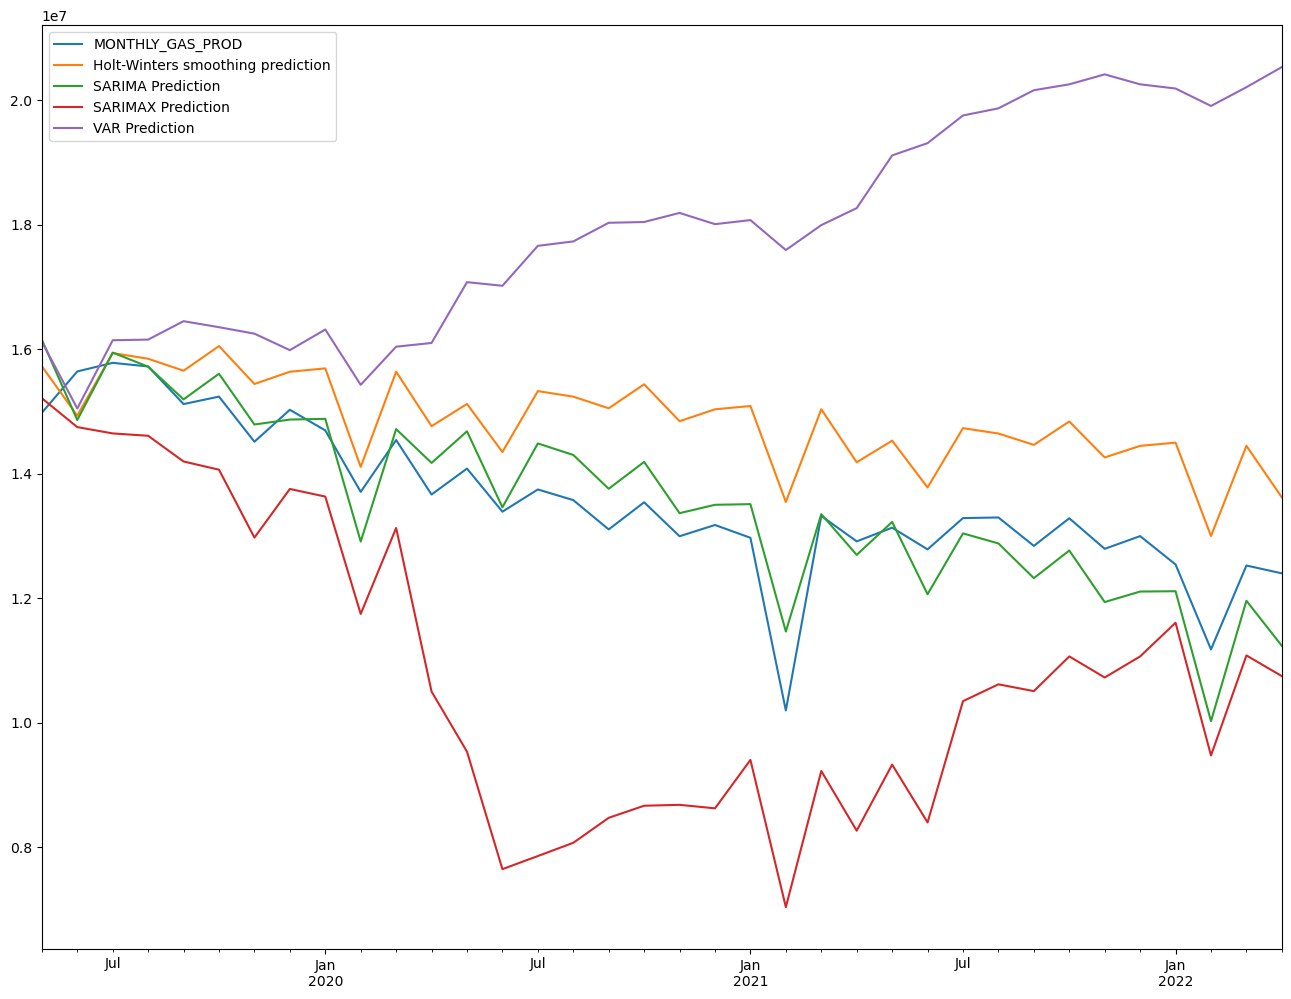

In [46]:
pd.DataFrame({'MONTHLY_GAS_PROD':xvalid['MONTHLY_GAS_PROD'],
              'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted,
              'SARIMAX Prediction':fittedx,
              'VAR Prediction':var_predictions['MONTHLY_GAS_PROD_predicted']}).plot()
plt.show()

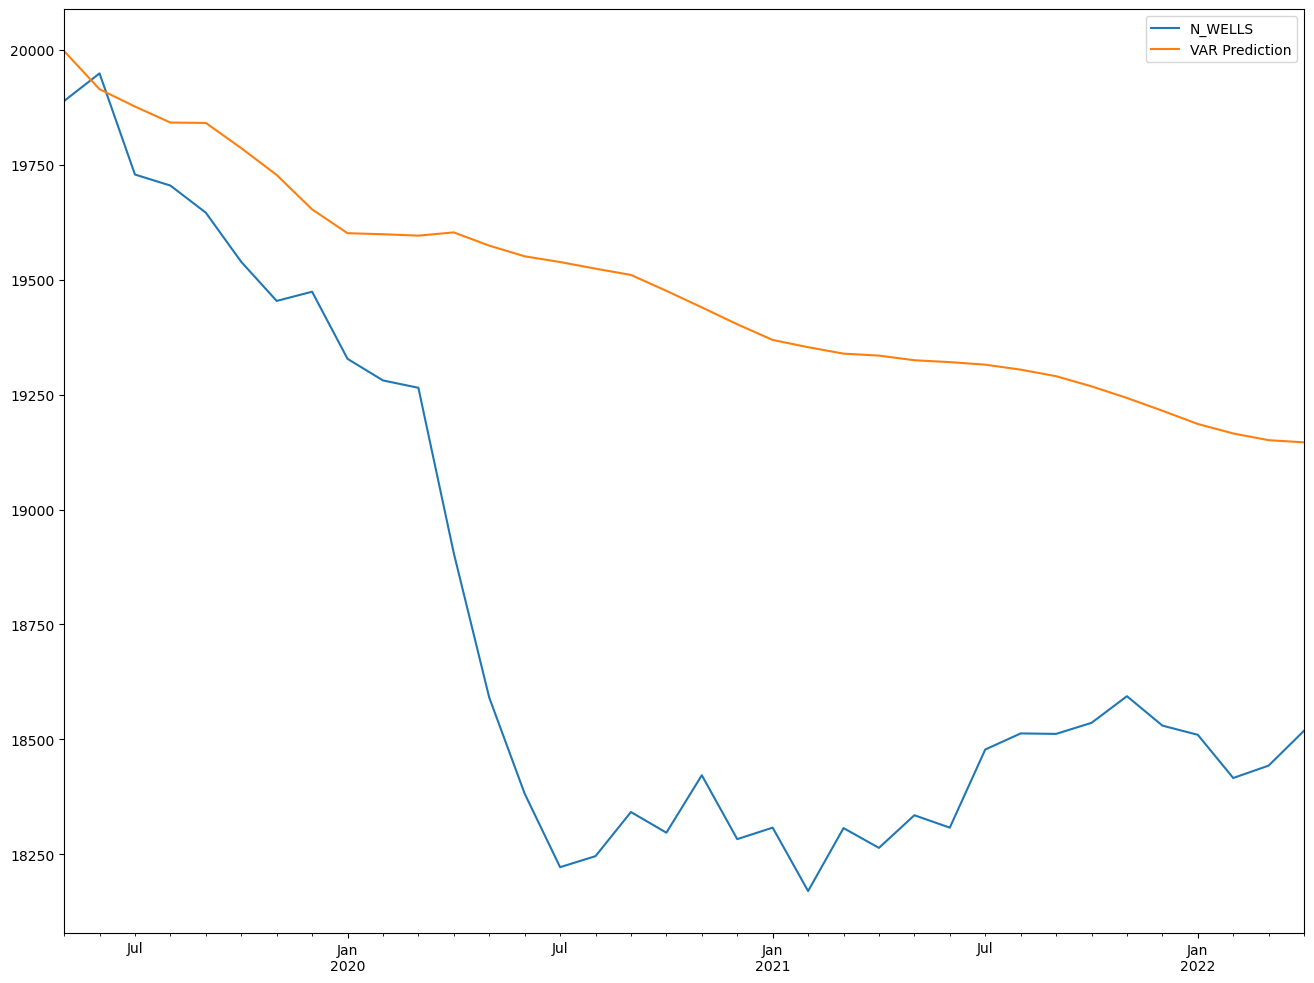

In [47]:
pd.DataFrame({'N_WELLS':xvalid['N_WELLS'],
              'VAR Prediction':var_predictions['NWELLS_predicted']}).plot()
plt.show()

In [48]:
lower_conf_var = pd.Series(var_CI['lower MONTHLY_GAS_PROD'], index=xvalid.index)
upper_conf_var = pd.Series(var_CI['upper MONTHLY_GAS_PROD'], index=xvalid.index)

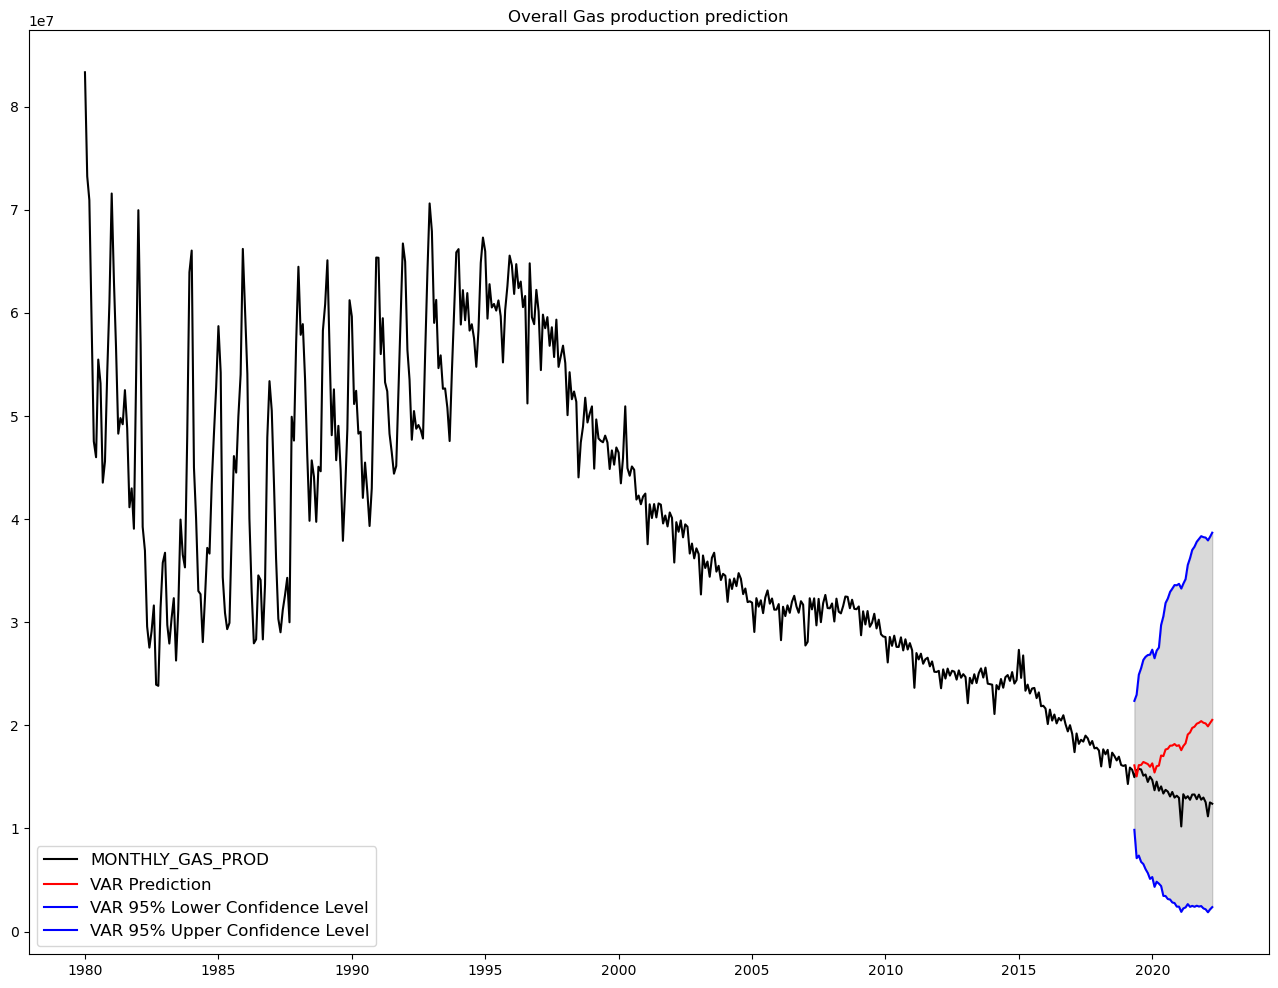

In [49]:
plt.plot(df_gas_prod['MONTHLY_GAS_PROD'], color='black', label='MONTHLY_GAS_PROD')
plt.plot(pd.Series(var_predictions['MONTHLY_GAS_PROD_predicted']), color='red', label='VAR Prediction')
plt.plot(lower_conf_var, color='blue', label='VAR 95% Lower Confidence Level')
plt.plot(upper_conf_var, color='blue', label='VAR 95% Upper Confidence Level')
plt.fill_between(lower_conf_var.index, 
                 lower_conf_var, 
                 upper_conf_var, 
                 color='k', alpha=.15)
plt.title('Overall Gas production prediction')
plt.legend(loc='lower left', fontsize=12)
plt.show()

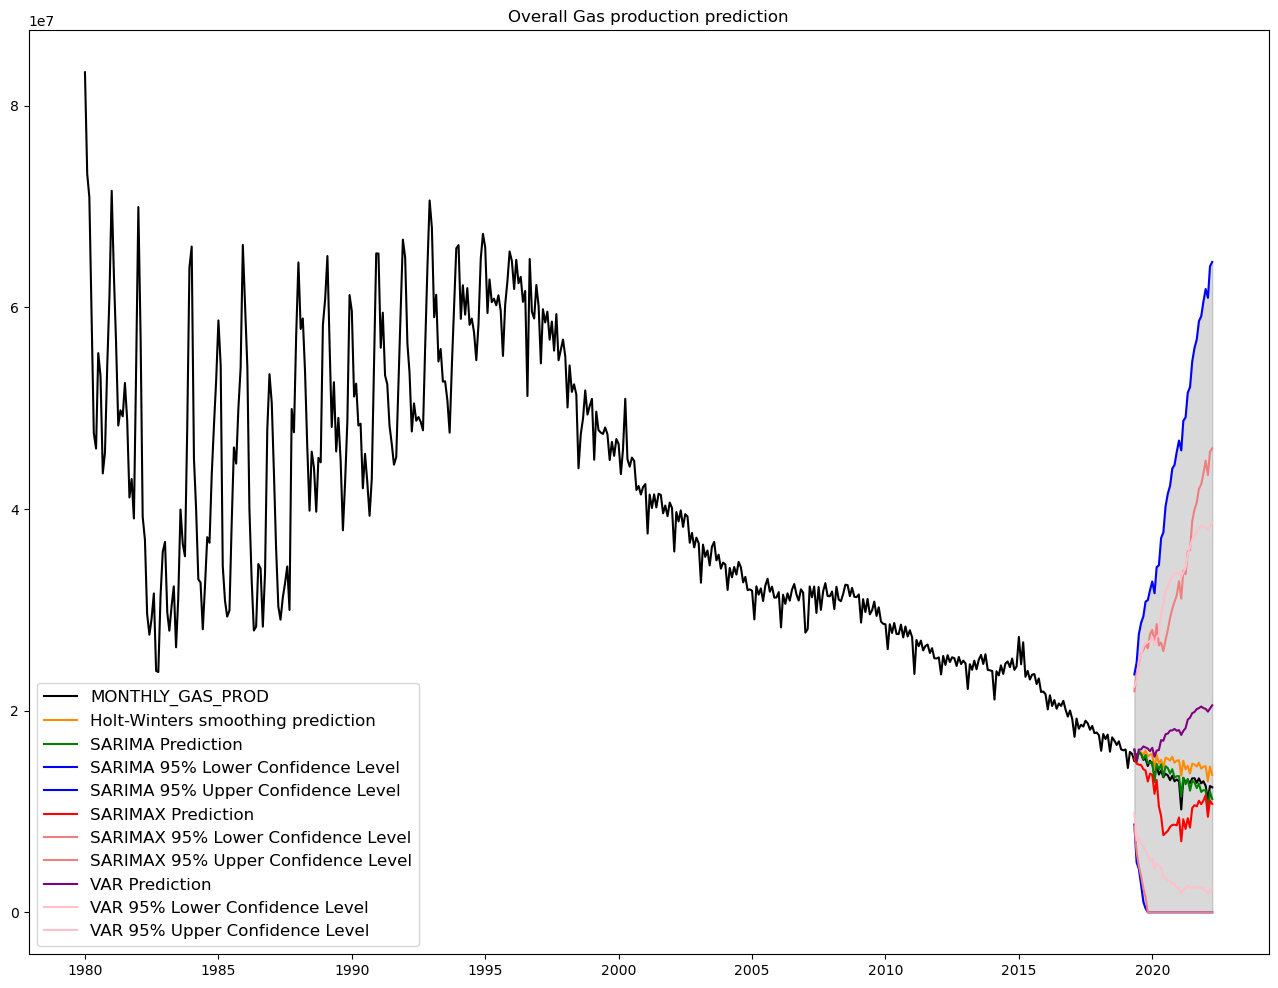

In [50]:
plt.plot(df_gas_prod['MONTHLY_GAS_PROD'], color='black', label='MONTHLY_GAS_PROD')

plt.plot(hw_pred, color='darkorange', label='Holt-Winters smoothing prediction')

plt.plot(pd.Series(fitted), color='green', label='SARIMA Prediction')
plt.plot(lower_conf, color='blue', label='SARIMA 95% Lower Confidence Level')
plt.plot(upper_conf, color='blue', label='SARIMA 95% Upper Confidence Level')

plt.plot(pd.Series(fittedx), color='red', label='SARIMAX Prediction')
plt.plot(lower_confx, color='lightcoral', label='SARIMAX 95% Lower Confidence Level')
plt.plot(upper_confx, color='lightcoral', label='SARIMAX 95% Upper Confidence Level')

plt.plot(pd.Series(var_predictions['MONTHLY_GAS_PROD_predicted']), color='purple', label='VAR Prediction')
plt.plot(lower_conf_var, color='pink', label='VAR 95% Lower Confidence Level')
plt.plot(upper_conf_var, color='pink', label='VAR 95% Upper Confidence Level')


plt.fill_between(lower_conf.index, 
                 lower_conf, 
                 upper_conf, 
                 color='k', alpha=.15)
plt.title('Overall Gas production prediction')
plt.legend(loc='lower left', fontsize=12)
plt.show()

**RMSE values**

In [51]:

gas_prod_mean = np.mean(xvalid['MONTHLY_GAS_PROD'])

rmse_hw = np.sqrt(mean_squared_error(hw_pred, xvalid['MONTHLY_GAS_PROD']))

rmse_sarima = np.sqrt(mean_squared_error(fitted, xvalid['MONTHLY_GAS_PROD']))

rmse_sarimax = np.sqrt(mean_squared_error(fittedx, xvalid['MONTHLY_GAS_PROD']))

rmse_var = np.sqrt(mean_squared_error(var_predictions['MONTHLY_GAS_PROD_predicted'], xvalid['MONTHLY_GAS_PROD']))

print('Mean value of MONTHLY_OIL_PROD is : {}, \nHolt-Winter Root Mean Squared Error is :{}, \
\nSARIMA Root Mean Squared Error is :{}, \nSARIMAX Root Mean Squared Error is :{}, \nVAR Root Mean Squared Error is :{}'
      .format(gas_prod_mean, rmse_hw, rmse_sarima, rmse_sarimax, rmse_var))

Mean value of MONTHLY_OIL_PROD is : 13576099.527777778, 
Holt-Winter Root Mean Squared Error is :1462928.3544590021, 
SARIMA Root Mean Squared Error is :616726.5384926987, 
SARIMAX Root Mean Squared Error is :3193708.3740563737, 
VAR Root Mean Squared Error is :5107436.982925405
